In [299]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

import os
import re
import pandas as pd
import numpy as np
import shutil
import subprocess
import multiprocessing
import re
import cantera as ct

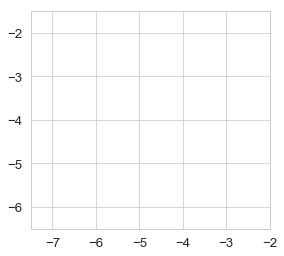

array([[[-7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   ,
         -7.5   , -7.5   ],
        [-6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125,
         -6.8125, -6.8125],
        [-6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 ,
         -6.125 , -6.125 ],
        [-5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375,
         -5.4375, -5.4375],
        [-4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  ,
         -4.75  , -4.75  ],
        [-4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625,
         -4.0625, -4.0625],
        [-3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 ,
         -3.375 , -3.375 ],
        [-2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875,
         -2.6875, -2.6875],
        [-2.    , -2.    , -2.    , -2.    , -2.    , -2.    , -2.    ,
         -2.    , -2.    ]],

       [[-6.5   , -5.875 , -5.25  , -4.625 , -4.    , -3.375 , -2.75  ,
         -2.125 , -1.5   ]

In [3]:
carbon_range = (-7.5, -2)
oxygen_range = (-6.5, -1.5)
grid_size = 9
mesh  = np.mgrid[carbon_range[0]:carbon_range[1]:grid_size*1j, 
                 oxygen_range[0]:oxygen_range[1]:grid_size*1j]

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
plt.show()
    
mesh

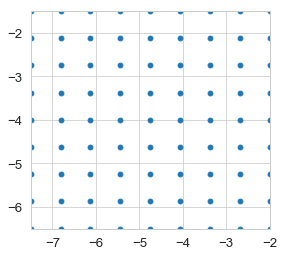

In [4]:
experiments = mesh.reshape((2,-1)).T

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.plot(*experiments.T, marker='o', linestyle='none')

In [5]:
extent = carbon_range + oxygen_range

# Because the center of a corner pixel is in fact the corner of the grid# Becaus 
# we want to stretch the image a little
c_step = mesh[0,1,0]-mesh[0,0,0]
o_step = mesh[1,0,1]-mesh[1,0,0]
carbon_range2 = (carbon_range[0]-c_step/2, carbon_range[1]+c_step/2)
oxygen_range2 = (oxygen_range[0]-c_step/2, oxygen_range[1]+c_step/2)
extent2 = carbon_range2 + oxygen_range2

In [250]:
def calculate(data):
    ratio = data[1]
    ch4_in = data[2]
    ch4_out = data[3]
    co_out = data[4]
    h2_out = data[5]
    h2o_out = data[6]
    co2_out = data[7]
    exit_T = data[8]
    max_T = data[9]
    dist_Tmax = data[10]
    
    ch4_depletion = ch4_in - ch4_out
    if ch4_depletion <= 0:
        ch4_depletion = 1e-15
    ch4_conv = ch4_depletion / ch4_in
    h2_sel = h2_out / (ch4_depletion * 2)
    h2_yield = h2_out / ( ch4_in * 2)
    co_sel = co_out / ch4_depletion
    co_yield = co_out / ch4_in
    syngas_sel = co_sel + h2_sel
    syngas_yield = syngas_sel * ch4_conv
    co2_sel = co2_out / ch4_depletion
    h2o_sel = h2o_out / (2 * ch4_depletion)
    fullox_sel = h2o_sel + co2_sel
    fullox_yield = fullox_sel * ch4_conv
    
    return syngas_sel, syngas_yield, co_sel, co_yield, h2_sel, h2_yield, ch4_conv, fullox_sel, fullox_yield, exit_T, max_T, dist_Tmax
    
def import_data(ratio, file_location=False):
    """
    This imports dict_conversions_celectivities from the original simulation
    """
    if file_location is False:
        data = pd.read_csv('./dict_conversions_selectivities.csv')
    else:
        data = pd.read_csv('./linearscaling/' + file_location + '/dict_conversions_selectivities.csv')
    
    data = data.get_values()
    for x in range(len(data)):
        r = round(data[x][1],1)
        if r == ratio:
            return calculate(data[x])


# For close packed surfaces from
# Abild-Pedersen, F.; Greeley, J.; Studt, F.; Rossmeisl, J.; Munter, T. R.; Moses, P. G.; Skúlason, E.; Bligaard, T.; Norskov, J. K. Scaling Properties of Adsorption Energies for Hydrogen-Containing Molecules on Transition-Metal Surfaces. Phys. Rev. Lett. 2007, 99 (1), 016105 DOI: 10.1103/PhysRevLett.99.016105.
abildpedersen_energies = { # Carbon, then Oxygen
'Ru': ( -6.397727272727272, -5.104763568600047),
'Rh': ( -6.5681818181818175, -4.609771721406942),
'Ni': ( -6.045454545454545, -4.711681807593758),
'Ir': ( -6.613636363636363, -5.94916142557652),
'Pd': ( -6, -3.517877940833916),
'Pt': ( -6.363636363636363, -3.481481481481482),
'Cu': ( -4.159090909090907, -3.85272536687631),
'Ag': ( -2.9545454545454533, -2.9282552993244817),
'Au': ( -3.7499999999999973, -2.302236198462614),
}


def lavaPlot(overall_rate, title, axis=False):
    """
    overall rate data to plot
    title is a string for what definition is used
    to normalize colors across many plots, False doesn't normalize axes 
    """
#     df = pd.DataFrame(index=np.unique(o_s), columns=np.unique(c_s))
#     print df
#     for c, o, t in zip(c_s, o_s, overall_rate):
#         df[c][o] = t
#     a = []
#     for i in df.values: 
#         a = a + list(i)

    overall_rate = np.array(overall_rate)
#     rates = 1./np.array(a)
    rates = overall_rate

    rates_grid = np.reshape(rates, (grid_size,grid_size))
    for i in range(0,8):  # transpose by second diagnol
        for j in range(0, 8 - i):
            rates_grid[i][j], rates_grid[8 - j][8 - i] = rates_grid[8 - j][8 - i], rates_grid[i][j]
    if axis is False:  # no normalizing
        plt.imshow(rates_grid, interpolation='spline16', origin='lower', 
                   extent=extent2, aspect='equal', cmap="Spectral_r",)
    else:
        plt.imshow(rates_grid, interpolation='spline16', origin='lower', 
                   extent=extent2, aspect='equal', cmap="Spectral_r", 
                   vmin=axis[0], vmax=axis[1],)
    for metal, coords in abildpedersen_energies.iteritems():
        color = {'Ag':'k','Au':'k','Cu':'k'}.get(metal,'k')
        plt.plot(coords[0], coords[1], 'o'+color)
        plt.text(coords[0], coords[1], metal, color=color)
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.xlabel('$\Delta E^C$ (eV)')
    plt.ylabel('$\Delta E^O$ (eV)')
    plt.title(str(title))
    plt.colorbar()
    out_dir = 'lsr'
    os.path.exists(out_dir) or os.makedirs(out_dir)
    plt.savefig(out_dir + '/' + str(title) +'.png', bbox_inches='tight')
    plt.show()  # comment out to save fig
    plt.clf()

SynGas Selectivity 1.3913544642901929e-11 83.45607162350001
SynGas Yield 7.301959703357164e-19 1.4959571543095207
CO Selectivity 1.165515599730815e-26 41.377027076
CO Yield 3.484852279976194e-33 0.818959937926673
H2 Selectivity 3.364600404083498e-12 42.079044547500004
H2 Yield 7.261829789029199e-19 0.7059125611921374
CH4 Conversion 9.136080852257513e-15 0.9841785006479921
CO2+H2O Selectivity 1.551686775707685e-11 1.9993558570103631
CO2+H2O Yield 4.1111369468831225e-21 0.5323000617670208
Exit Temperature 699.994447005 1883.05018955
Maximum Temperature 700.0 1932.60356299
Dist to Max Temperature 0.01 70.0


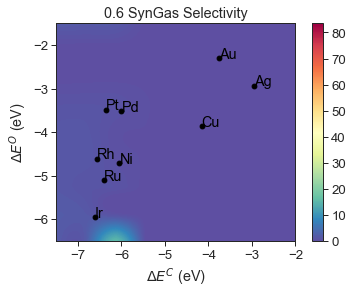

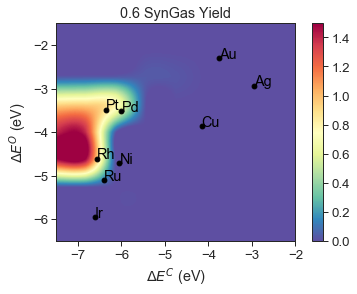

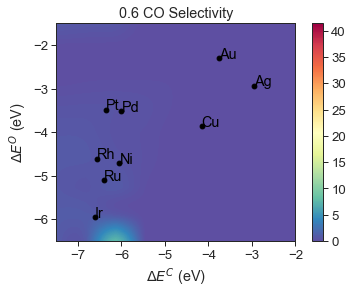

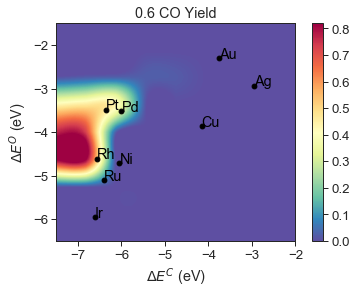

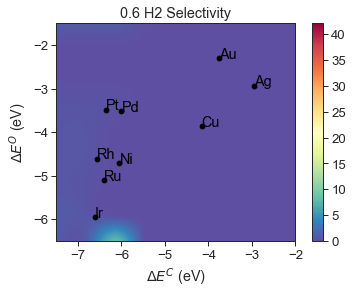

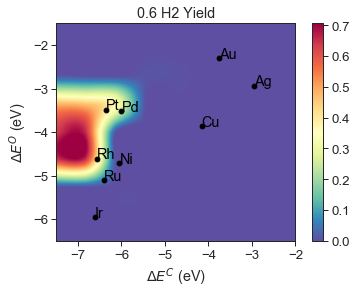

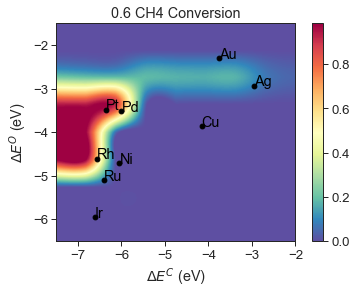

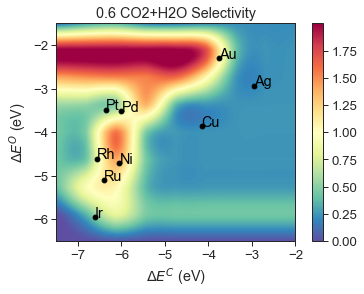

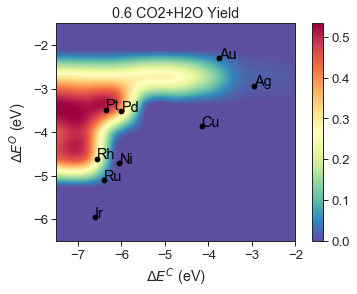

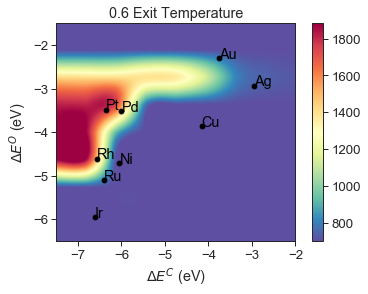

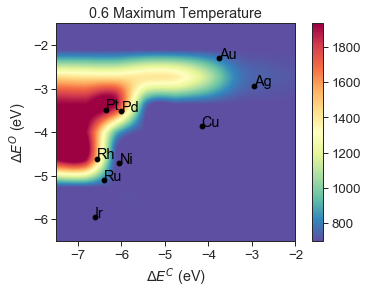

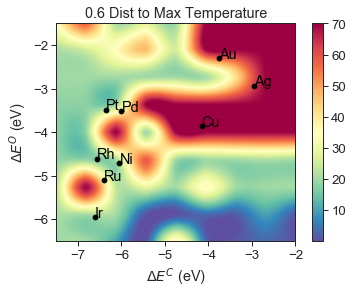

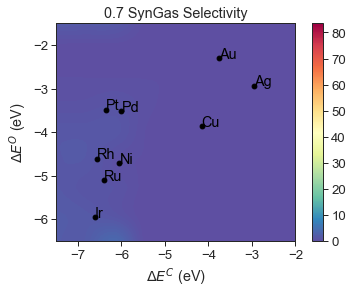

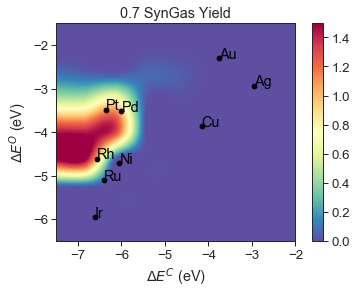

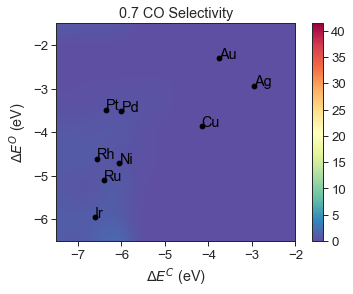

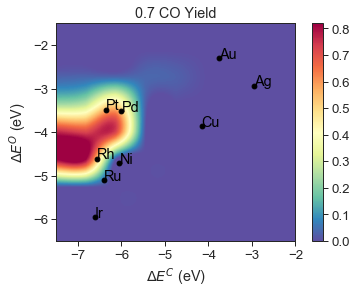

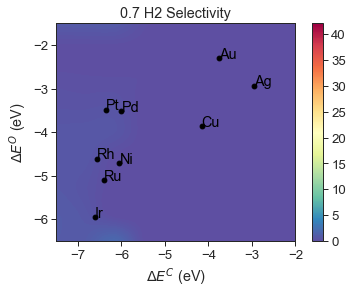

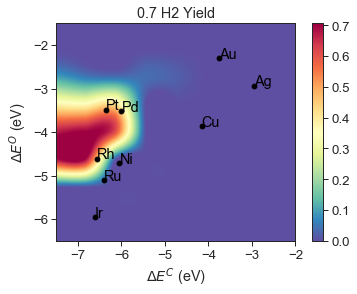

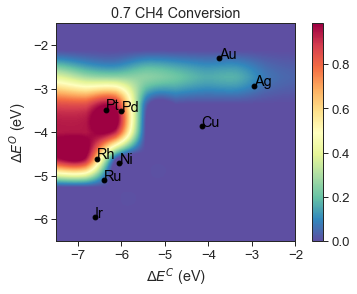

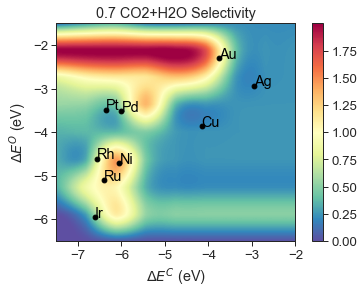

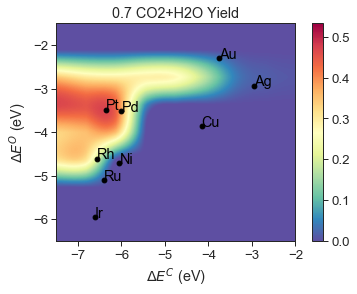

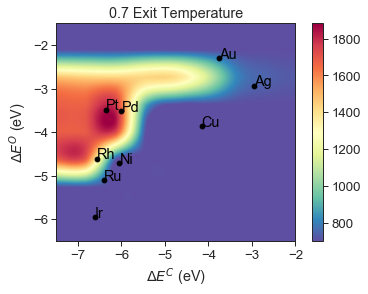

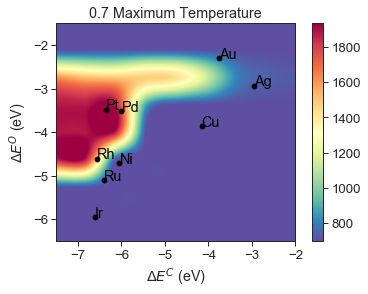

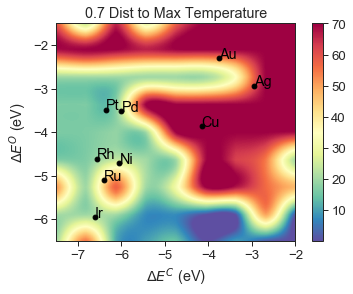

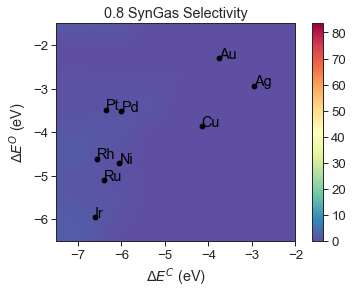

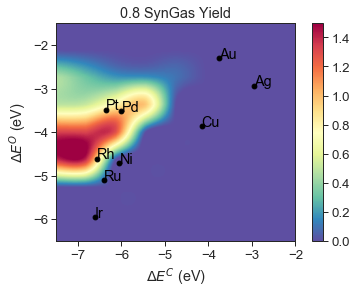

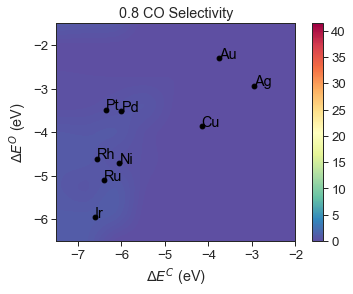

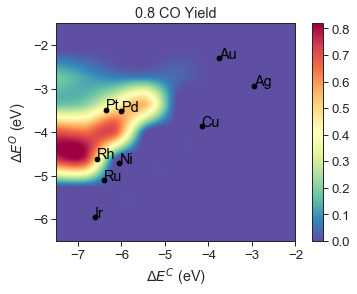

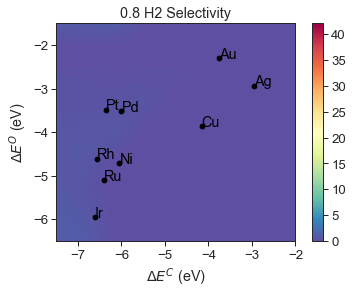

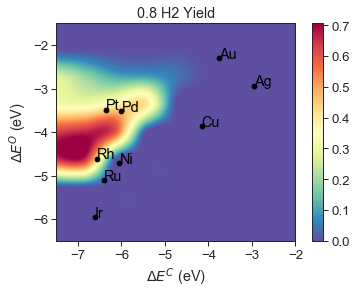

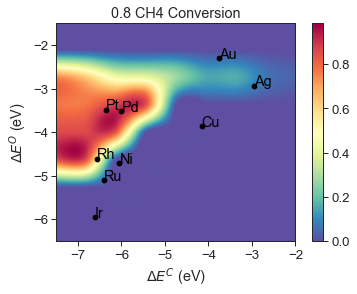

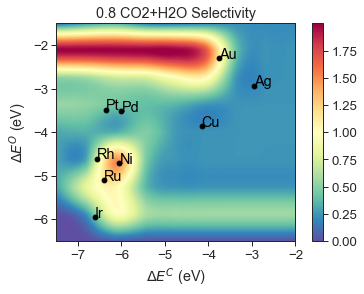

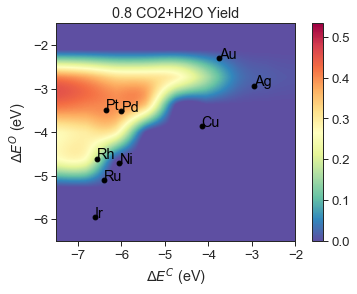

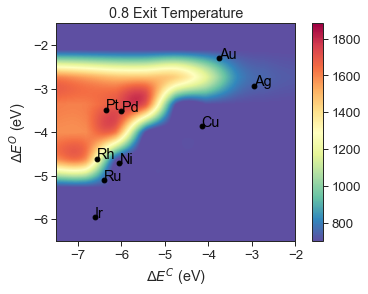

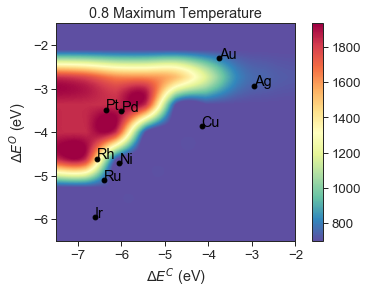

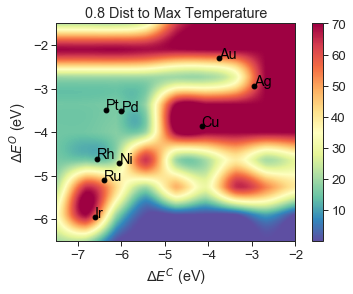

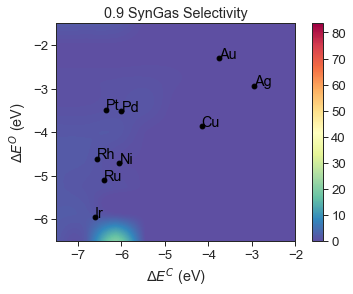

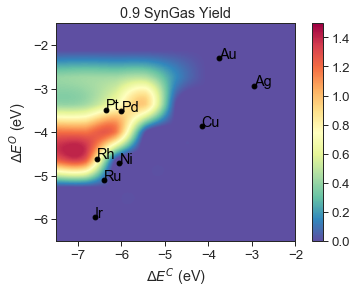

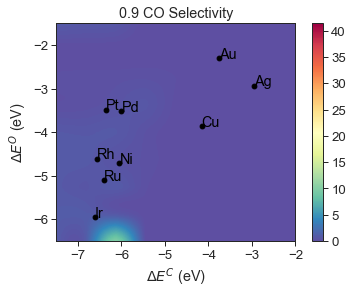

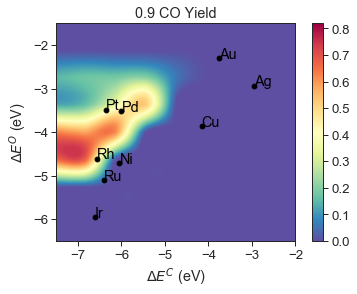

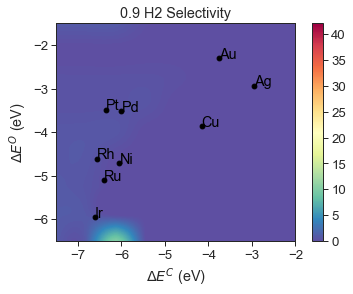

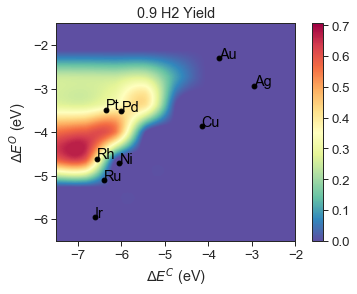

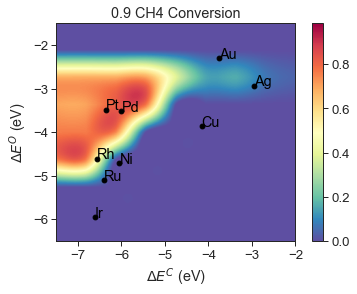

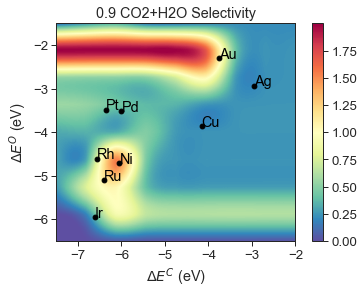

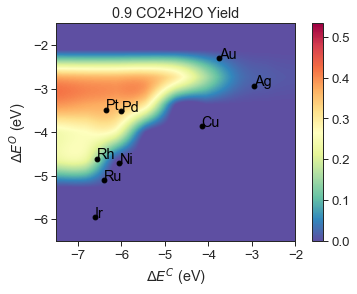

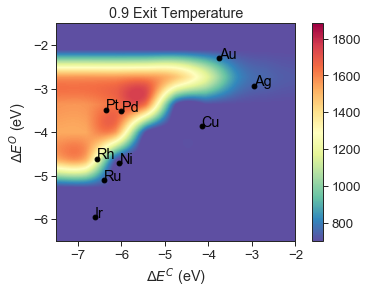

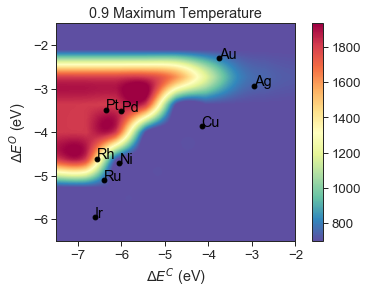

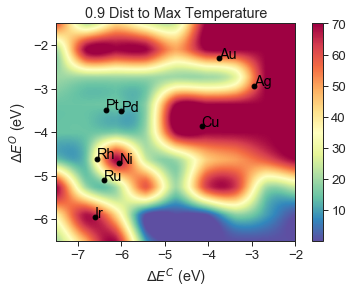

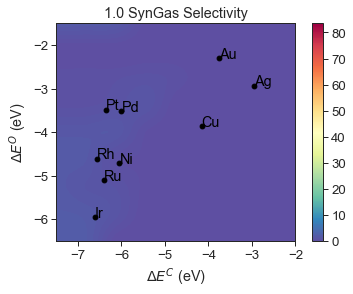

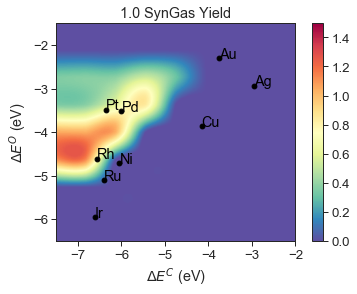

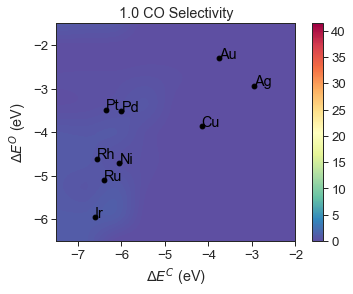

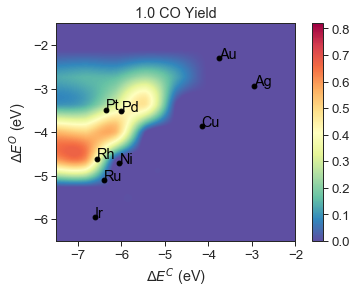

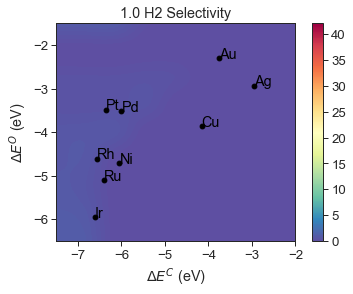

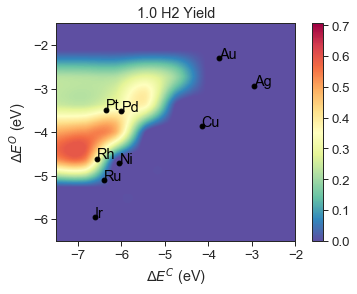

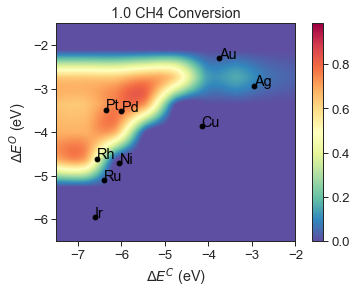

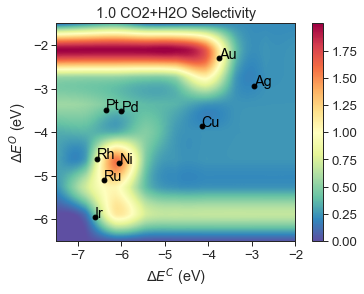

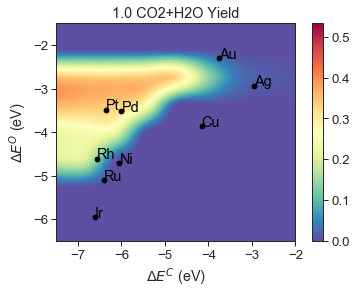

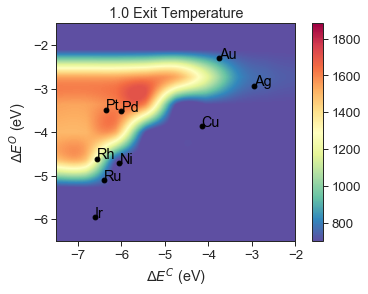

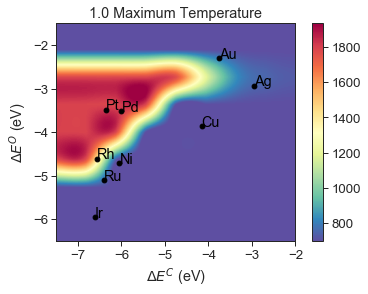

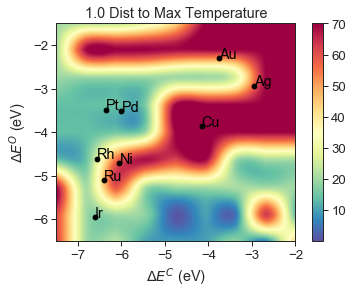

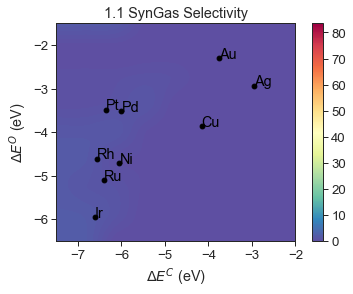

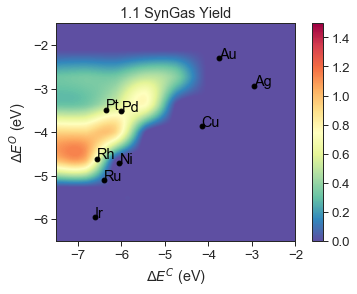

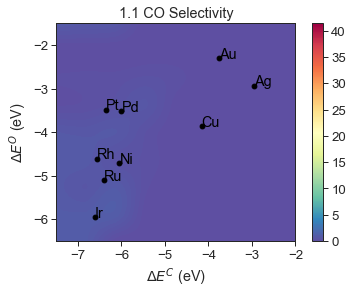

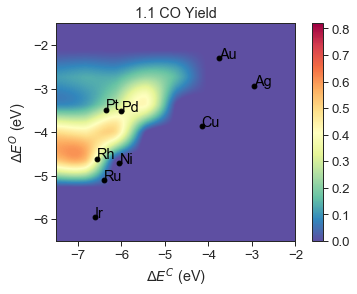

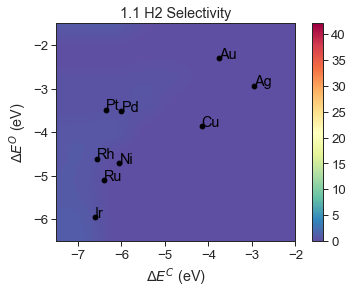

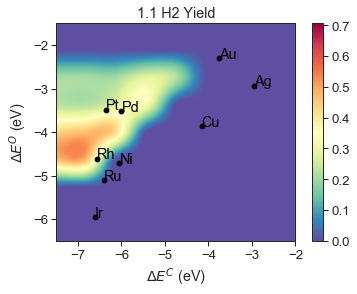

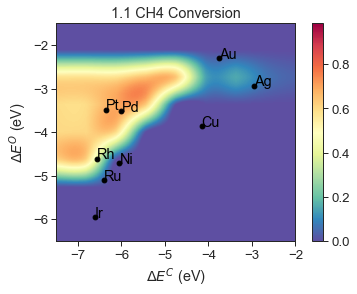

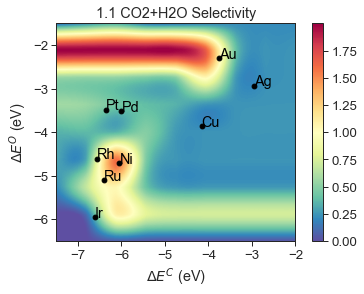

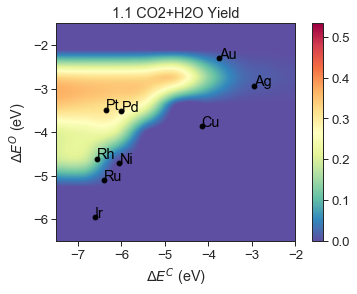

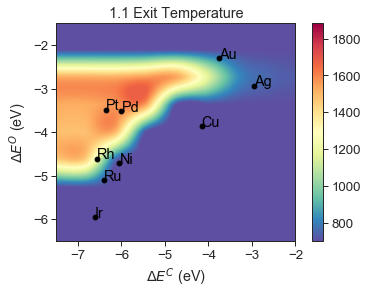

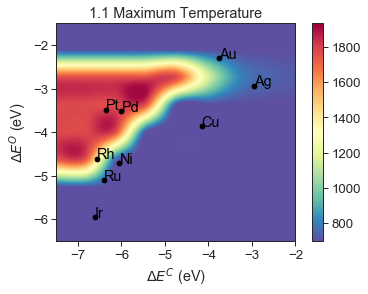

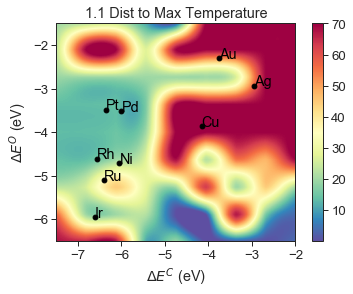

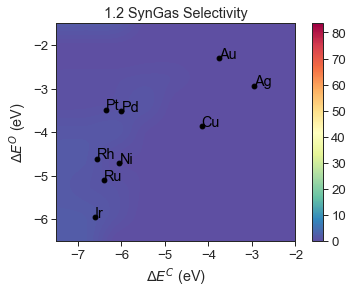

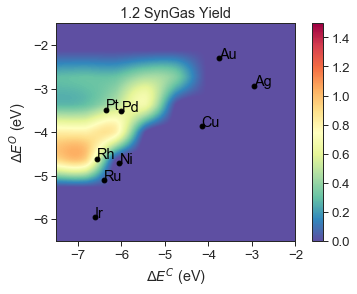

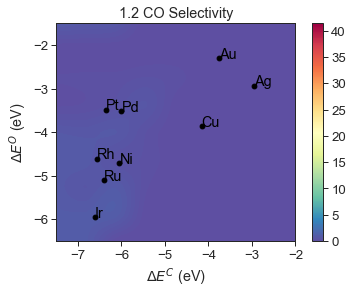

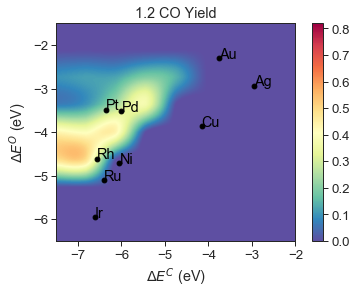

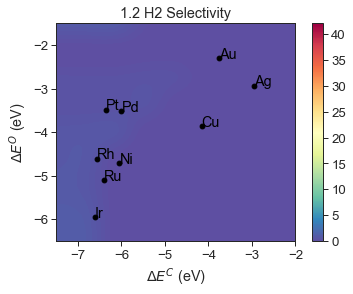

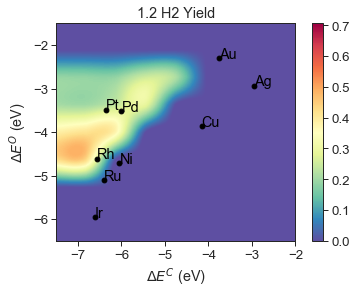

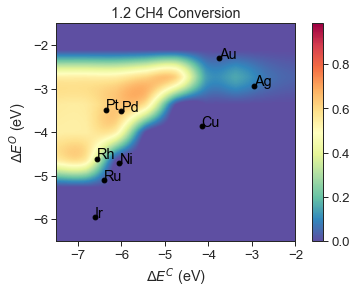

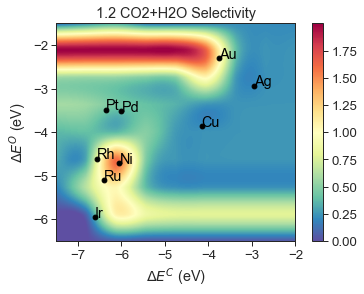

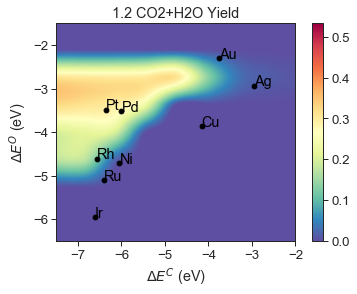

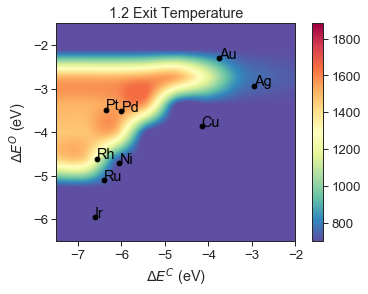

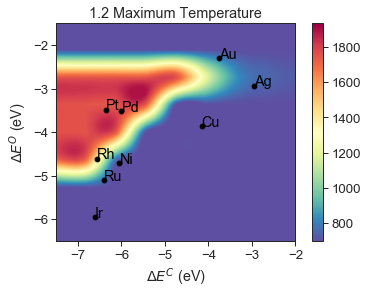

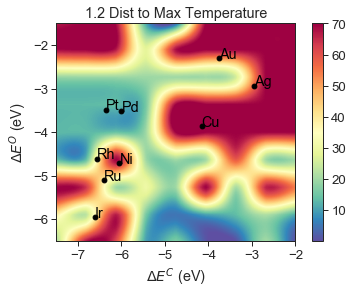

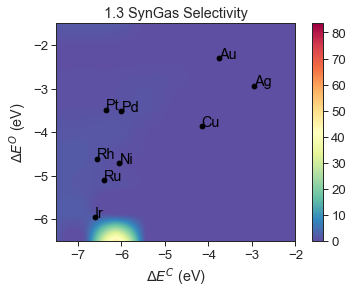

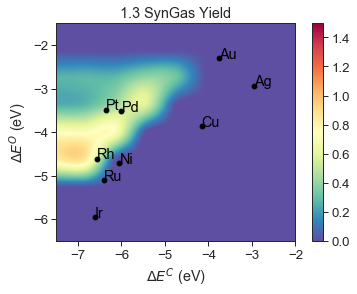

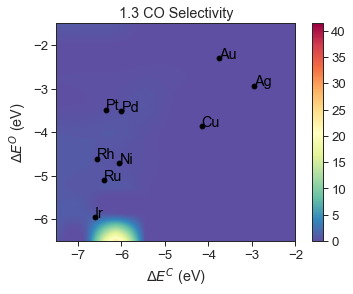

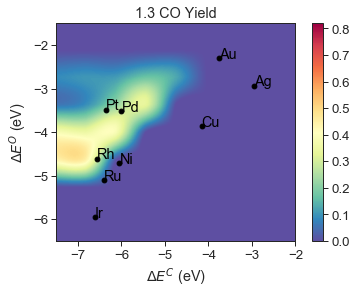

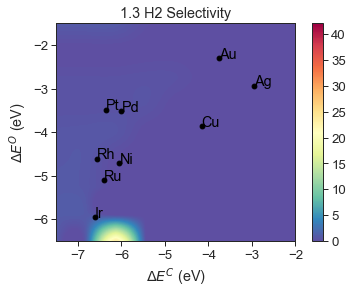

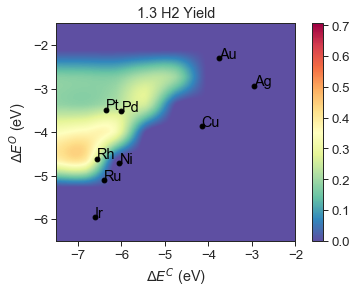

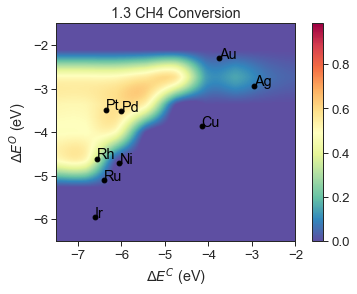

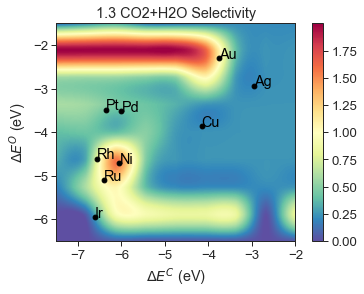

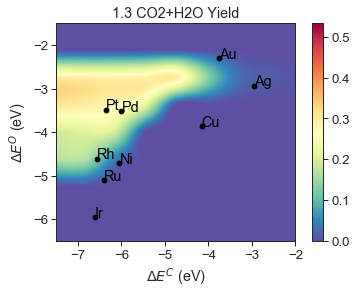

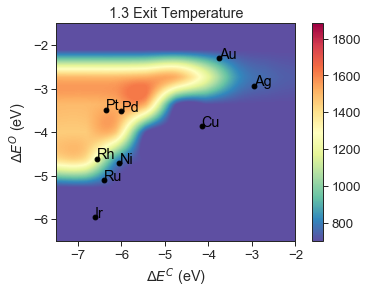

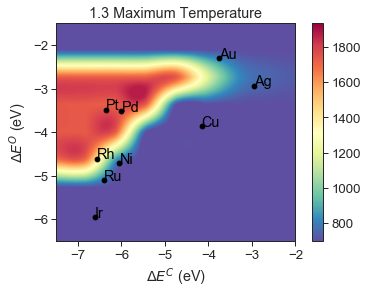

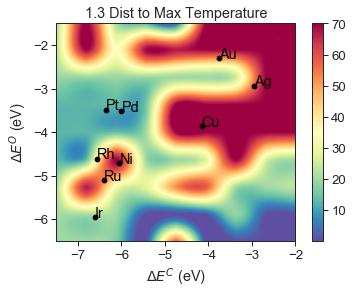

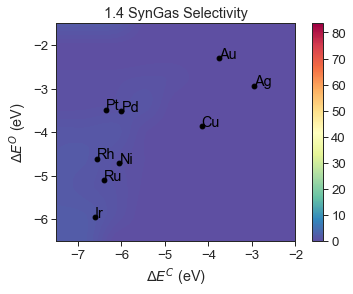

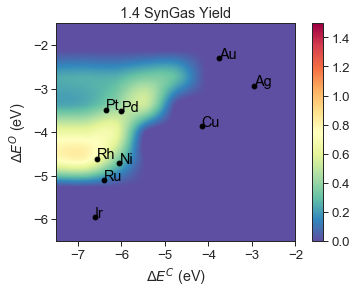

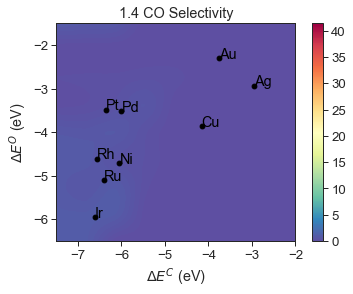

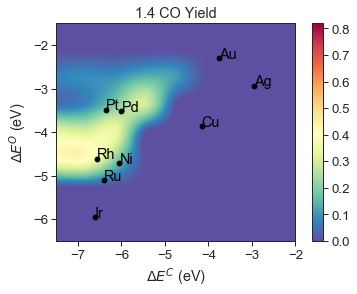

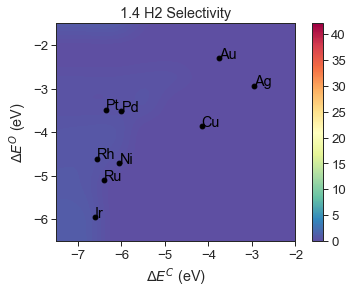

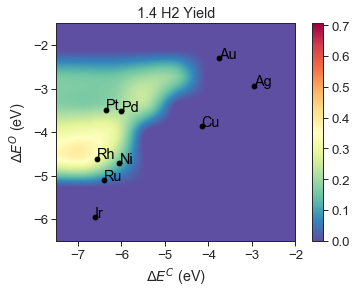

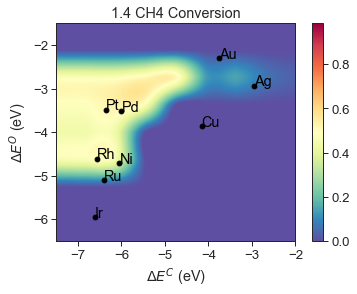

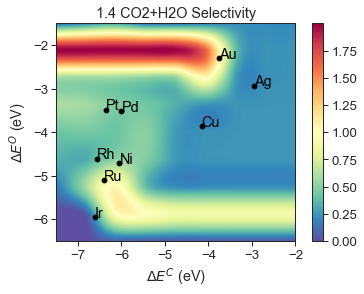

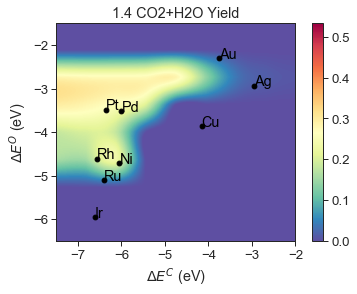

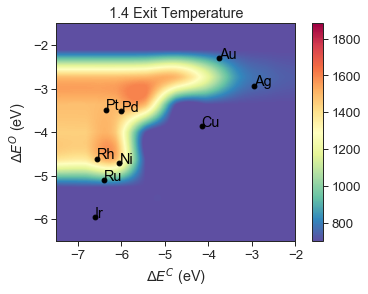

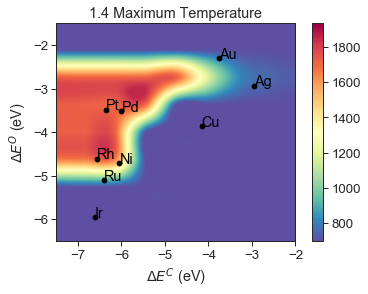

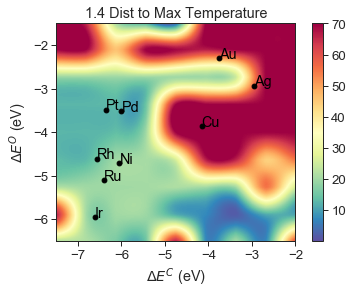

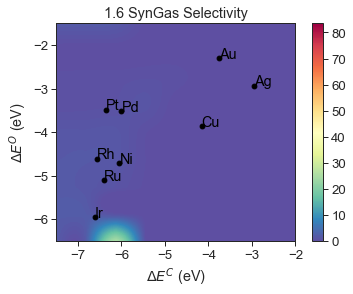

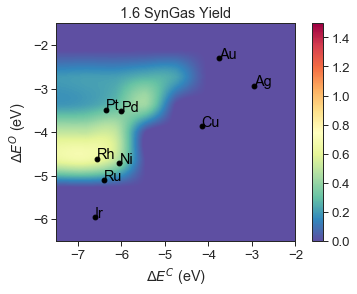

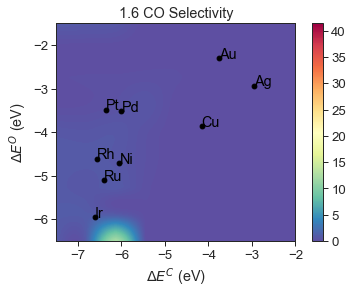

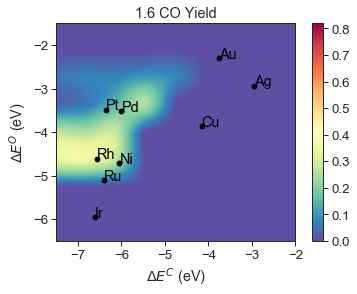

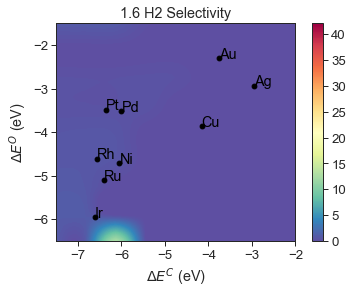

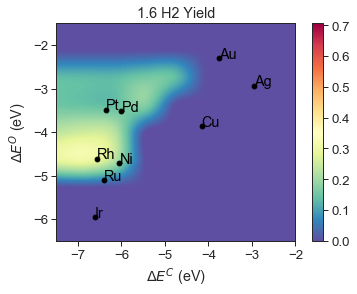

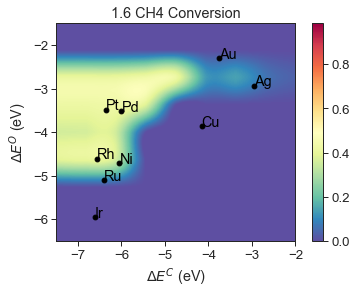

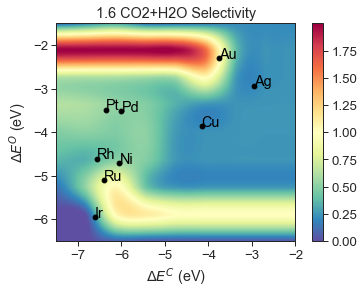

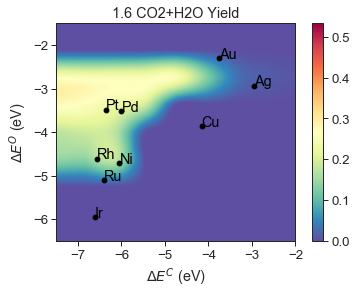

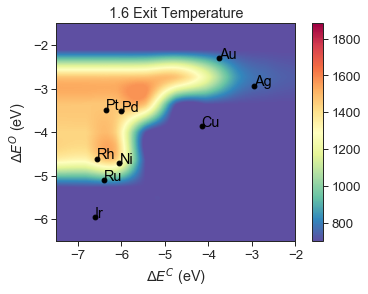

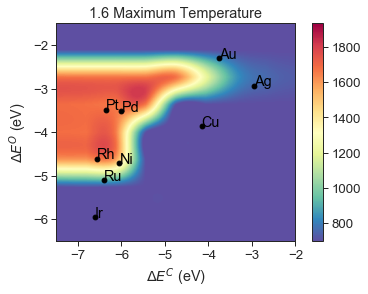

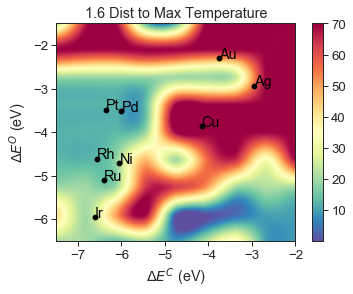

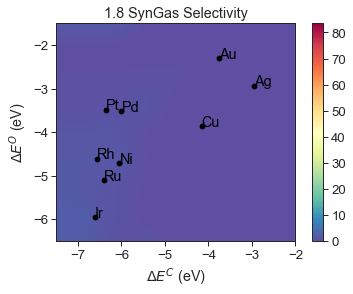

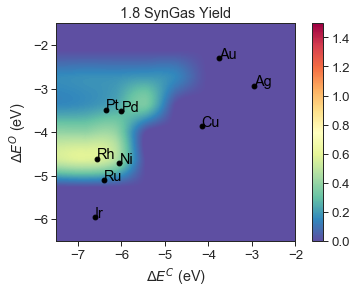

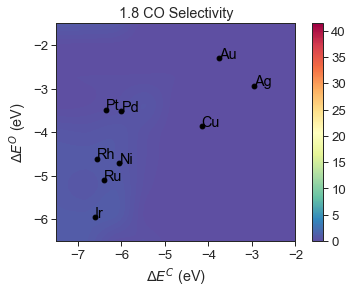

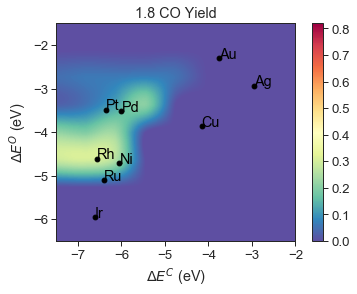

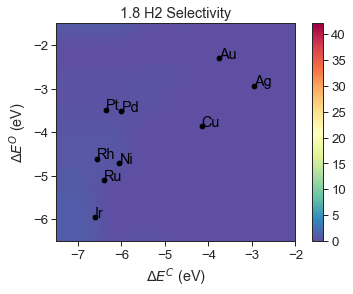

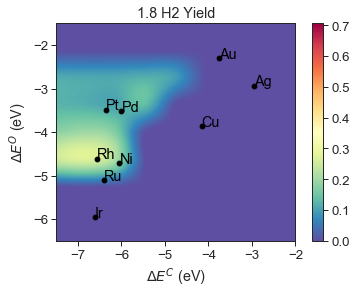

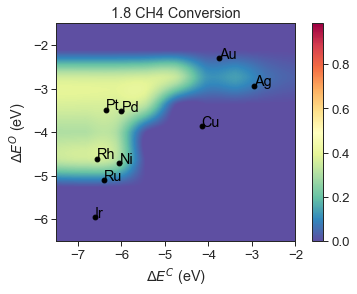

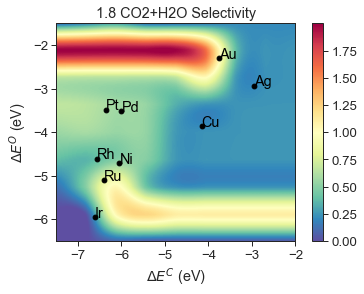

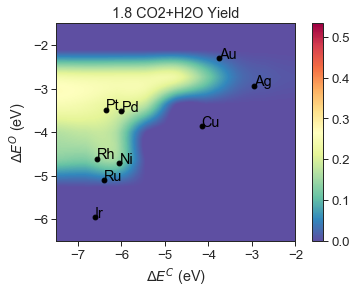

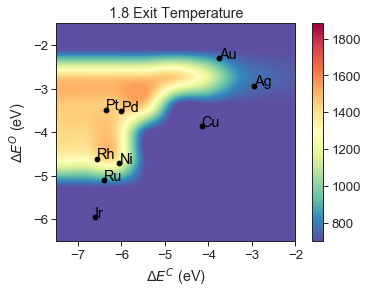

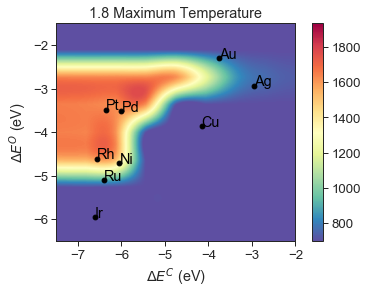

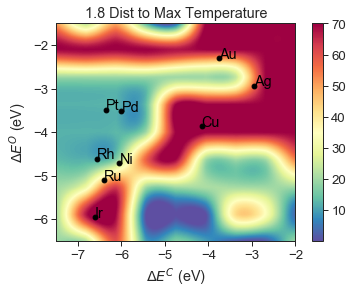

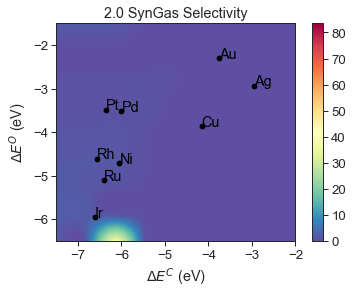

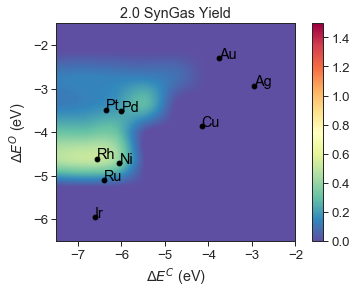

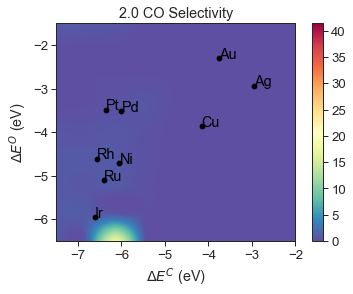

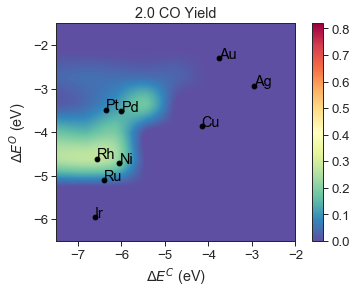

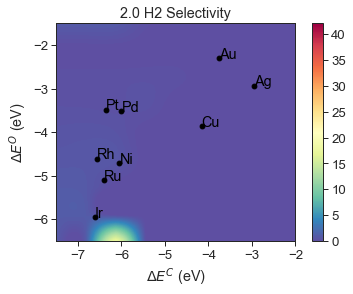

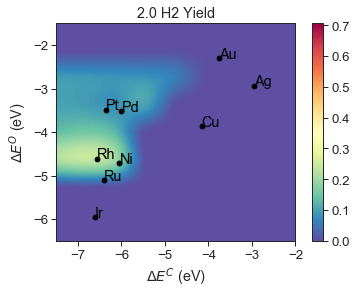

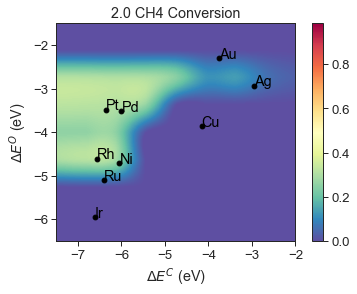

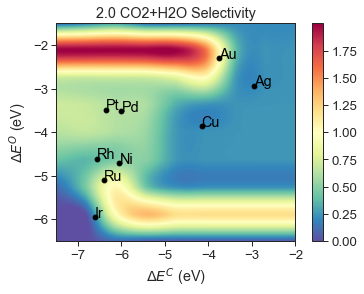

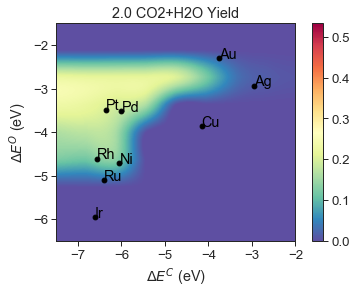

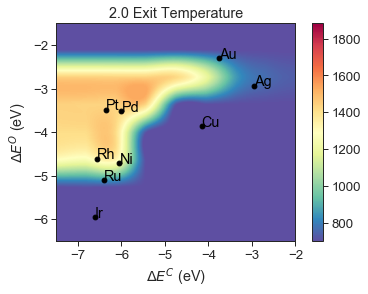

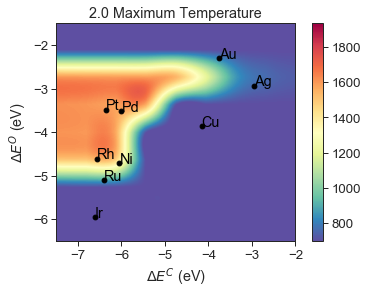

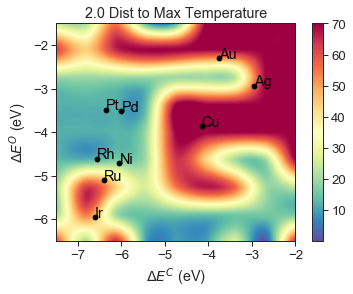

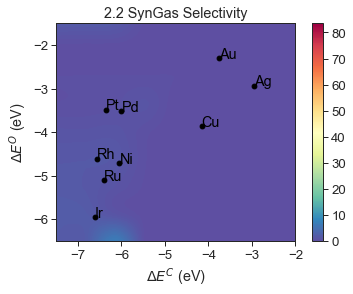

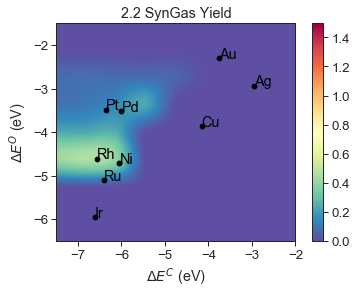

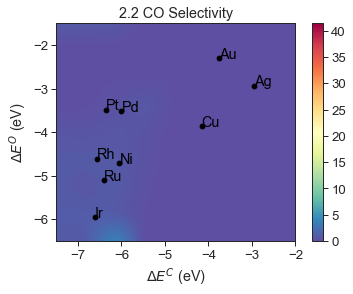

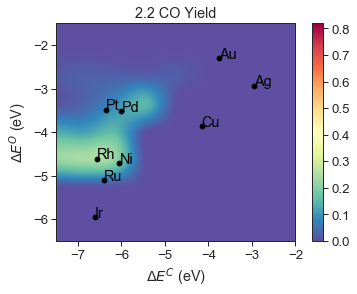

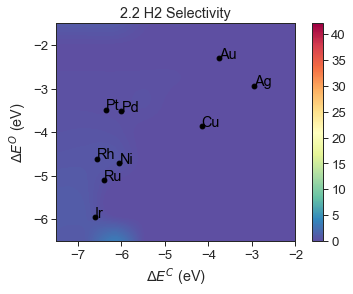

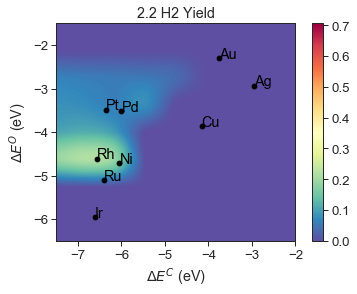

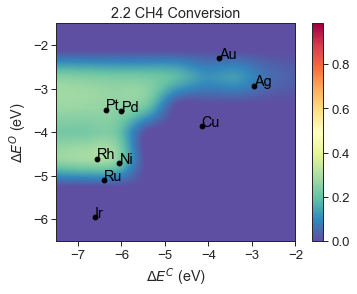

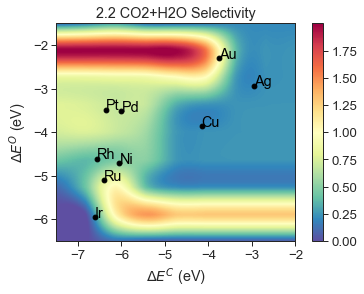

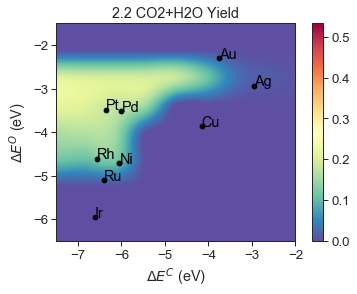

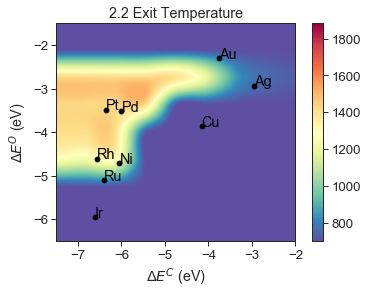

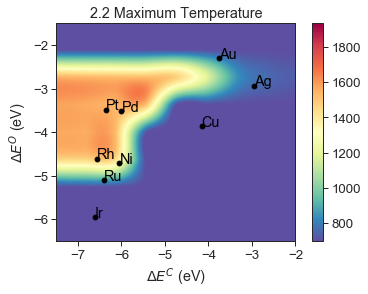

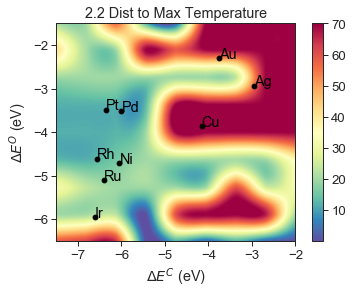

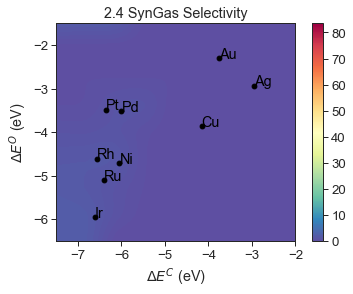

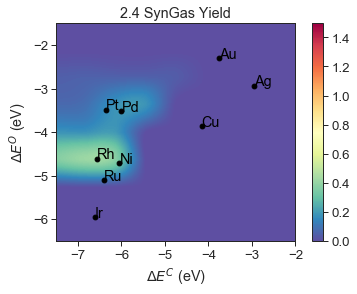

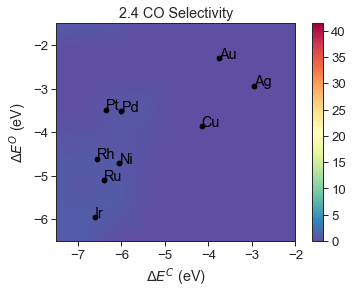

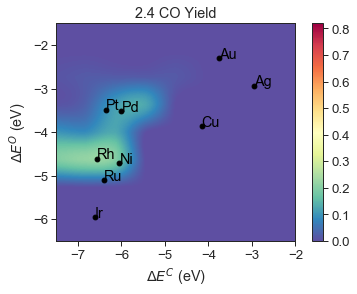

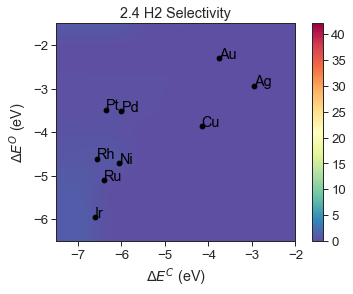

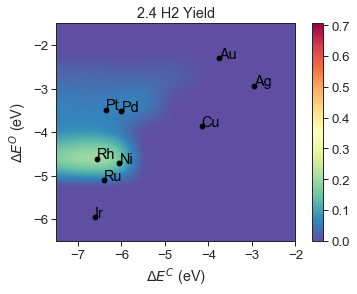

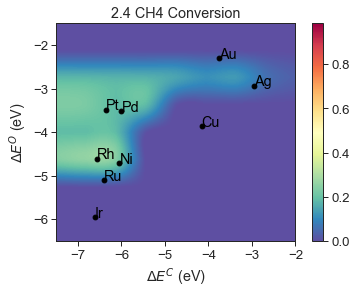

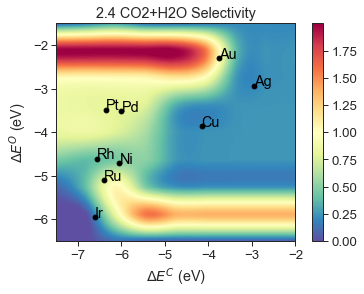

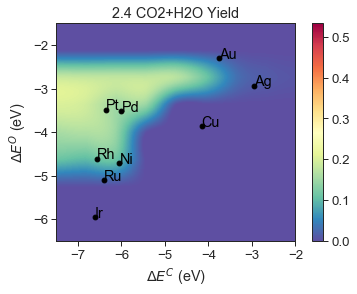

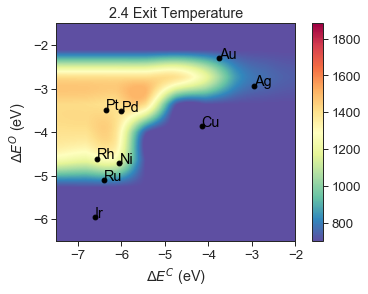

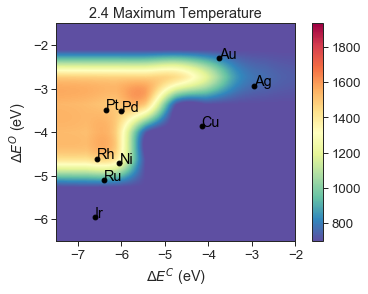

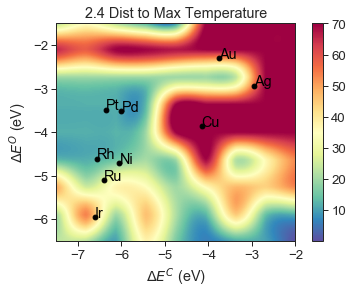

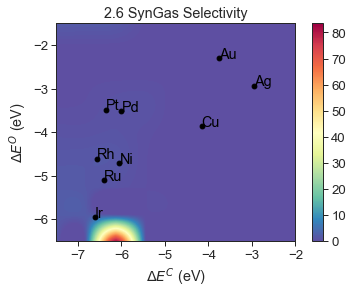

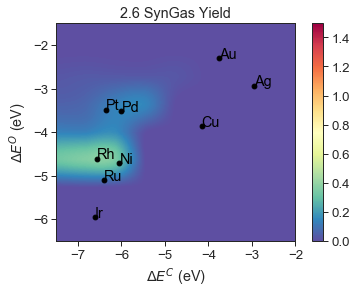

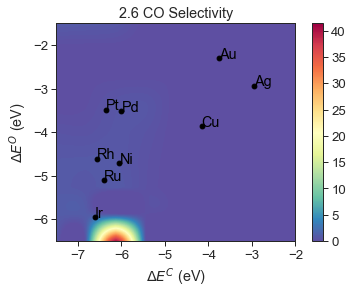

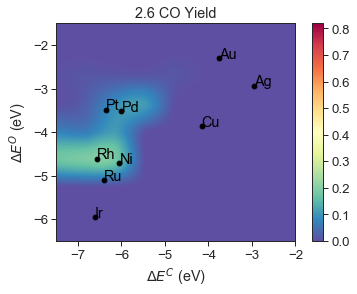

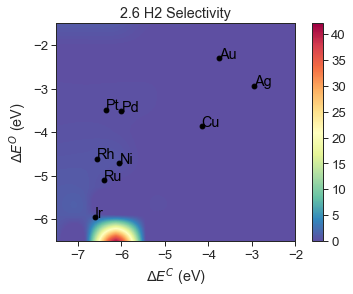

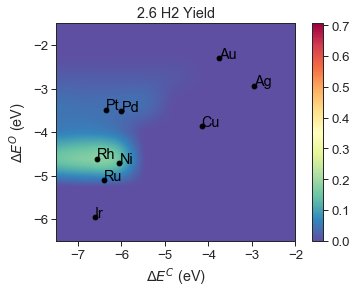

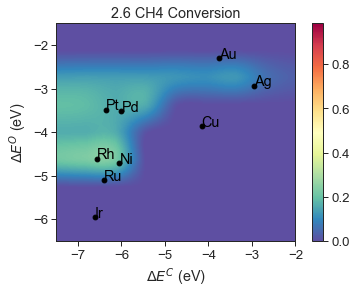

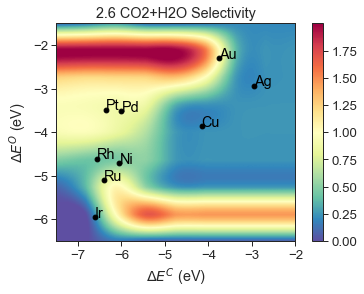

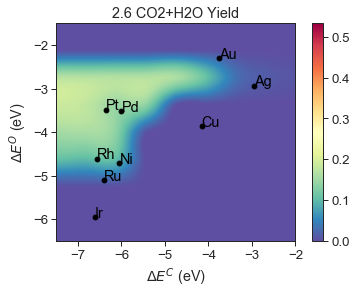

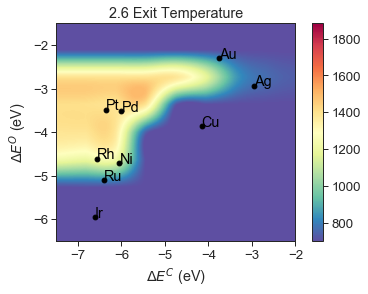

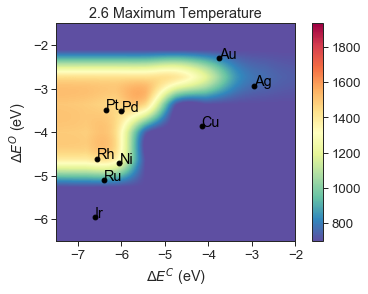

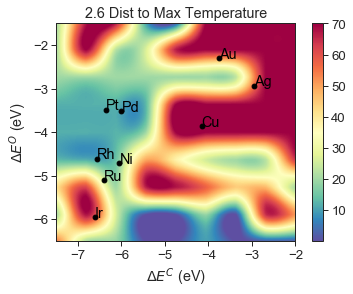

<Figure size 432x288 with 0 Axes>

In [251]:
array = os.listdir('./linearscaling/')
array = sorted(array)

# for plotting
c_s = []
o_s = []
for x in array:
    _, c, o = x.split("-")
    c = c[:-1]
    c = -1 *float(c)
    o = -1* float(o)
    c_s.append(c)
    o_s.append(o)

ratios = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
sens_types = ['SynGas Selectivity', 'SynGas Yield', 'CO Selectivity', 'CO Yield',
              'H2 Selectivity', 'H2 Yield', 'CH4 Conversion', 'CO2+H2O Selectivity',
              'CO2+H2O Yield', 'Exit Temperature', 'Maximum Temperature', 
              'Dist to Max Temperature']
all_data = []
for ratio in ratios:
    ans = []
    for f in array:
        ans.append(import_data(ratio, file_location=f))
    all_data.append(ans)

#     for s in range(len(ans[0])):  # plot each original sens value
#         data_to_plot = []
#         for x in range(len(ans)):
#             data_to_plot.append(ans[x][s])
#         title = str(ratio) + ' ' + sens_types[s]
#         lavaPlot(data_to_plot, title)  # making plots
    
    
# to normalize colors across ratios
spans = []
for m in range(len(all_data[0][0])):  # for each sens definition
    all_sens_data = []
    for x in range(len(all_data)):  # for each ratio
        for y in range(len(all_data[0])):
            # x has len 15 and is each of the ratios
            # y has len 81 and is each of the lsr binding energies
            # the last number is the type of sensitivity definition and is 0-12
            all_sens_data.append(all_data[x][y][m])
    vmax = max(all_sens_data)
    vmin = min(all_sens_data)
    spans.append([vmin, vmax])
    print sens_types[m], vmin, vmax

for z in range(len(all_data)):
    ans = all_data[z]
    for s in range(len(ans[0])):
        data_to_plot = []
        for x in range(len(ans)):
            data_to_plot.append(ans[x][s])
        title = str(ratios[z]) + ' ' + sens_types[s]
        lavaPlot(data_to_plot, title, axis=spans[s])  # making plots


In [338]:
def import_sensitivities(ratio, file_location=False, thermo=False):
    """
    Ratio is the C/O starting gas ratio
    file_location is the LSR C and O binding energy, fasle to load the base case
    thermo is either False to load reaction sensitivities or True to load thermo sensitivities
    """
    try:
        # load in the sensitivity csv files
        if file_location is False:
            if thermo is False:
                data = pd.read_csv('./sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
            else:
                data = pd.read_csv('./sensitivities/' + str(ratio) + 'ThermoSensitivity.csv')
        else:
            if thermo is False:
                data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
            else:
                data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(ratio) + 'ThermoSensitivity.csv')
        data = data.get_values()
        data = data.tolist()
        return data
    except:
        if thermo is False:
            print('Cannot find ' + str(ratio) + 'RxnSensitivity.csv for:    ' + file_location)
        else:
            print('Cannot find ' + str(ratio) + 'ThermoSensitivity.csv for: ' + file_location)
        # try loading the reactions from a different ratio to use as placeholders
        try_ratios = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
        for r in try_ratios:
            try:
                if file_location is False:
                    if thermo is False:
                        data = pd.read_csv('./sensitivities/' + str(r) + 'RxnSensitivity.csv')
                    else:
                        data = pd.read_csv('./sensitivities/' + str(r) + 'ThermoSensitivity.csv')
                else:
                    if thermo is False:
                        data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(r) + 'RxnSensitivity.csv')
                    else:
                        data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(r) + 'ThermoSensitivity.csv')
                data = data.get_values()
                fakedata = data
#                 fakedata = np.zeros_like(data, dtype=float)
                for x in range(len(data)):
                    for y in xrange(2,14):
                        fakedata[x][y] = 0.0
                return fakedata.tolist()
                break
            except:
                continue

In [339]:
allrxndata = []  # where all rxn sens itivities will be stored
allthermodata = []  # where all thermo sensitivities will be stored
for f in array:
    rxndata = []
    thermodata = []
    for ratio in ratios:
        rxndata.append(import_sensitivities(ratio, file_location=f))
#         thermodata.append(import_sensitivities(ratio, file_location=f, thermo=True))
    allrxndata.append(rxndata)
#     allthermodata.append(thermodata)

Cannot find 0.9RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 1.4RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 1.6RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 2.0RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 2.2RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 2.4RxnSensitivity.csv for:    c-6.125o-1.500


In [316]:
num_surf_reactions = []
for x in array:
    gas = ct.Solution('./linearscaling/' + x + '/chem_annotated.cti', 'gas')
    surf = ct.Interface('./linearscaling/' + x + '/chem_annotated.cti', 'surface1', [gas])
    num_surf_reactions.append(surf.n_reactions)

# allrxndata[lsr BEs][c/o ratios][surface reactions][1=reaction, 2-14=sensitivities]

In [377]:
reactions = []
for f in range(len(allrxndata)):
    for r in range(len(allrxndata[0][0])):
        reactions.append(allrxndata[f][0][r][1])
rxns_unique = np.unique(reactions)

for rxn in rxns_unique:  # for a certain reaction
    for r in range(len(allrxndata[0])):  # for a single ratio
        for s in xrange(2,14):  # for a sensitivity type
            sensitivities = []
            got_value = False
            for f in range(len(array)):  # for lsr binding energies
                for p in range(len(allrxndata[f][r])):  # matching the reaction
                    if allrxndata[f][r][p] == rxn:
                        sensitivities.append(allrxndata[f][r][p][s])
                        got_value = True
                if got_value is False:  # put a placeholder in
                    sensitivities.append(0.)
            title = rxn + ' '+ sens_types[s-2] + ' ' + str(ratios[r])
            
            MAX = 5  # this is arbitrary... maybe write in a find for the max sens ever
            
            # cull out the boring plots
            count = 0
            for a in sensitivities:
                if abs(a)>1e-9:
                    count += 1
            if count < 5:
                print "skipping {} because it's boring".format(title)
                continue
                
            lavaPlot(sensitivities, title, axis=[-1 * MAX, MAX])

skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7 because it's borin

skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 2.0 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 2.0 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 2.0 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 2.2 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 2.2 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 2.2 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 2.2 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 2.2 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 2.2 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 2.2 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 2.2 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 2.2 because it's boring
skipping 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 2.2 because it's boring


skipping C + 2 [Pt] <=> C[Pt] + [Pt] CO2+H2O Selectivity 1.4 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] CO2+H2O Yield 1.4 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] Exit Temperature 1.4 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] Maximum Temperature 1.4 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] Dist to Max Temperature 1.4 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] SynGas Selectivity 1.6 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] SynGas Yield 1.6 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] CO Selectivity 1.6 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] CO Yield 1.6 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] H2 Selectivity 1.6 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] H2 Yield 1.6 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] CH4 Conversion 1.6 because it's boring
skipping C + 2 [Pt] <=> C[Pt] + [Pt] CO2+H2O Selectivity 1.6 because it's bori

skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] H2 Yield 1.0 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] CH4 Conversion 1.0 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] CO2+H2O Selectivity 1.0 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] CO2+H2O Yield 1.0 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] Exit Temperature 1.0 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] Maximum Temperature 1.0 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] Dist to Max Temperature 1.0 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] SynGas Selectivity 1.1 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] SynGas Yield 1.1 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] CO Selectivity 1.1 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] CO Yield 1.1 because it's boring
skipping C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] H2 Selectivity 1.1 be

skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CH4 Conversion 0.6 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CO2+H2O Selectivity 0.6 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CO2+H2O Yield 0.6 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] Exit Temperature 0.6 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] Maximum Temperature 0.6 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] Dist to Max Temperature 0.6 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] SynGas Selectivity 0.7 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] SynGas Yield 0.7 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CO Selectivity 0.7 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CO Yield 0.7 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] H2 Selectivity 0.7 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] H2 Yield 0.7 be

skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] H2 Yield 2.2 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CH4 Conversion 2.2 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CO2+H2O Selectivity 2.2 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CO2+H2O Yield 2.2 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] Exit Temperature 2.2 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] Maximum Temperature 2.2 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] Dist to Max Temperature 2.2 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] SynGas Selectivity 2.4 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] SynGas Yield 2.4 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CO Selectivity 2.4 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] CO Yield 2.4 because it's boring
skipping C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] H2 Selectivity 2.4 be

skipping C + [Pt] <=> C.[Pt] Exit Temperature 1.6 because it's boring
skipping C + [Pt] <=> C.[Pt] Maximum Temperature 1.6 because it's boring
skipping C + [Pt] <=> C.[Pt] Dist to Max Temperature 1.6 because it's boring
skipping C + [Pt] <=> C.[Pt] SynGas Selectivity 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] SynGas Yield 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] CO Selectivity 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] CO Yield 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] H2 Selectivity 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] H2 Yield 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] CH4 Conversion 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] CO2+H2O Selectivity 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] CO2+H2O Yield 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] Exit Temperature 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] Maximum Temperature 1.8 because it's boring
skipping C + [Pt] <=> C.[Pt] Di

skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] CO2+H2O Selectivity 1.2 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] CO2+H2O Yield 1.2 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] Exit Temperature 1.2 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] Maximum Temperature 1.2 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] Dist to Max Temperature 1.2 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] SynGas Selectivity 1.3 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] SynGas Yield 1.3 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] CO Selectivity 1.3 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] CO Yield 1.3 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] H2 Selectivity 1.3 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] H2 Yield 1.3 because it's boring
skipping C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt] CH4 Conversion 1.3 because it's b

skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] Exit Temperature 0.9 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] Maximum Temperature 0.9 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] Dist to Max Temperature 0.9 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] SynGas Selectivity 1.0 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] SynGas Yield 1.0 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] CO Selectivity 1.0 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] CO Yield 1.0 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] H2 Selectivity 1.0 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] H2 Yield 1.0 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] CH4 Conversion 1.0 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] CO2+H2O Selectivity 1.0 because it's boring
skipping C#[Pt] + [Pt] <=> C=[Pt] + [Pt] CO2+H2O Yield 1.0 because it's boring
skipping C#[Pt] + [Pt] <=> C=[

skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] SynGas Yield 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CO Selectivity 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CO Yield 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] H2 Selectivity 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] H2 Yield 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CH4 Conversion 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CO2+H2O Selectivity 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CO2+H2O Yield 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] Exit Temperature 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] Maximum Temperature 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] Dist to Max Temperature 0.7 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] SynGas Selectivity 0.8 because it's boring
skipping C#[Pt] + [Pt] <=> C~[

skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] Exit Temperature 2.4 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] Maximum Temperature 2.4 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] Dist to Max Temperature 2.4 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] SynGas Selectivity 2.6 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] SynGas Yield 2.6 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CO Selectivity 2.6 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CO Yield 2.6 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] H2 Selectivity 2.6 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] H2 Yield 2.6 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CH4 Conversion 2.6 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CO2+H2O Selectivity 2.6 because it's boring
skipping C#[Pt] + [Pt] <=> C~[Pt] + [Pt] CO2+H2O Yield 2.6 because it's boring
skipping C#[Pt] + [Pt] <=> C~[

skipping C=C + [Pt] <=> C=C.[Pt] CO Yield 2.0 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] H2 Selectivity 2.0 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] H2 Yield 2.0 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] CH4 Conversion 2.0 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] CO2+H2O Selectivity 2.0 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] CO2+H2O Yield 2.0 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] Exit Temperature 2.0 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] Maximum Temperature 2.0 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] Dist to Max Temperature 2.0 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] SynGas Selectivity 2.2 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] SynGas Yield 2.2 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] CO Selectivity 2.2 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] CO Yield 2.2 because it's boring
skipping C=C + [Pt] <=> C=C.[Pt] H2 Selectivity 2.2 because 

skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] H2 Yield 1.4 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] CH4 Conversion 1.4 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] CO2+H2O Selectivity 1.4 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] CO2+H2O Yield 1.4 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] Exit Temperature 1.4 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] Maximum Temperature 1.4 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] Dist to Max Temperature 1.4 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] SynGas Selectivity 1.6 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] SynGas Yield 1.6 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] CO Selectivity 1.6 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] CO Yield 1.6 because it's boring
skipping C=O + 2 [Pt] <=> O=C[Pt] + [Pt] H2 Selectivity 1.6 because it's boring
skipping C=O + 2 [Pt] <=> O=C[

skipping C=O + [Pt] <=> C=O.[Pt] H2 Selectivity 1.1 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] H2 Yield 1.1 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] CH4 Conversion 1.1 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] CO2+H2O Selectivity 1.1 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] CO2+H2O Yield 1.1 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] Exit Temperature 1.1 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] Maximum Temperature 1.1 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] Dist to Max Temperature 1.1 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] SynGas Selectivity 1.2 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] SynGas Yield 1.2 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] CO Selectivity 1.2 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] CO Yield 1.2 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] H2 Selectivity 1.2 because it's boring
skipping C=O + [Pt] <=> C=O.[Pt] H2 Yield 1.2 because 

skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CH4 Conversion 0.8 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CO2+H2O Selectivity 0.8 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CO2+H2O Yield 0.8 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] Exit Temperature 0.8 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] Maximum Temperature 0.8 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] Dist to Max Temperature 0.8 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] SynGas Selectivity 0.9 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] SynGas Yield 0.9 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CO Selectivity 0.9 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CO Yield 0.9 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] H2 Selectivity 0.9 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] H2 Yield 0.9 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CH4 Conversion 0.9 because i

skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] Maximum Temperature 2.4 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] Dist to Max Temperature 2.4 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] SynGas Selectivity 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] SynGas Yield 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CO Selectivity 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CO Yield 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] H2 Selectivity 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] H2 Yield 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CH4 Conversion 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CO2+H2O Selectivity 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] CO2+H2O Yield 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] Exit Temperature 2.6 because it's boring
skipping C=[Pt] + C~[Pt] <=> 2 C#[Pt] Maximum Temperature 2.6 beca

skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] CH4 Conversion 1.6 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] CO2+H2O Selectivity 1.6 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] CO2+H2O Yield 1.6 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] Exit Temperature 1.6 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] Maximum Temperature 1.6 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] Dist to Max Temperature 1.6 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] SynGas Selectivity 1.8 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] SynGas Yield 1.8 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] CO Selectivity 1.8 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] CO Yield 1.8 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] H2 Selectivity 1.8 because it's boring
skipping C=[Pt] + O=C[Pt] <=> C[Pt] + 

skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] SynGas Yield 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] CO Selectivity 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] CO Yield 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] H2 Selectivity 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] H2 Yield 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] CH4 Conversion 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] CO2+H2O Selectivity 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] CO2+H2O Yield 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] Exit Temperature 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] Maximum Temperature 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] Dist to Max Temperature 1.1 because it's boring
skipping C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt] SynGas Selectivity 1.2 because it's boring
skippi

skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CO Yield 0.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] H2 Selectivity 0.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] H2 Yield 0.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CH4 Conversion 0.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CO2+H2O Selectivity 0.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CO2+H2O Yield 0.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] Exit Temperature 0.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] Maximum Temperature 0.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] Dist to Max Temperature 0.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] SynGas Selectivity 0.7 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] SynGas Yield 0.7 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CO Selectivity 0.7 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CO

skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] Maximum Temperature 1.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] Dist to Max Temperature 1.6 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] SynGas Selectivity 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] SynGas Yield 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CO Selectivity 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CO Yield 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] H2 Selectivity 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] H2 Yield 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CH4 Conversion 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CO2+H2O Selectivity 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] CO2+H2O Yield 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] Exit Temperature 1.8 because it's boring
skipping C=[Pt] + [Pt] <=> C[Pt] + [Pt] Ma

skipping CC + 2 [Pt] <=> 2 C[Pt] SynGas Yield 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] CO Selectivity 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] CO Yield 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] H2 Selectivity 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] H2 Yield 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] CH4 Conversion 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] CO2+H2O Selectivity 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] CO2+H2O Yield 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] Exit Temperature 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] Maximum Temperature 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] Dist to Max Temperature 1.2 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] SynGas Selectivity 1.3 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] SynGas Yield 1.3 because it's boring
skipping CC + 2 [Pt] <=> 2 C[Pt] CO Selectivity 1.3 beca

skipping CC + [Pt] <=> CC.[Pt] CO2+H2O Selectivity 0.8 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CO2+H2O Yield 0.8 because it's boring
skipping CC + [Pt] <=> CC.[Pt] Exit Temperature 0.8 because it's boring
skipping CC + [Pt] <=> CC.[Pt] Maximum Temperature 0.8 because it's boring
skipping CC + [Pt] <=> CC.[Pt] Dist to Max Temperature 0.8 because it's boring
skipping CC + [Pt] <=> CC.[Pt] SynGas Selectivity 0.9 because it's boring
skipping CC + [Pt] <=> CC.[Pt] SynGas Yield 0.9 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CO Selectivity 0.9 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CO Yield 0.9 because it's boring
skipping CC + [Pt] <=> CC.[Pt] H2 Selectivity 0.9 because it's boring
skipping CC + [Pt] <=> CC.[Pt] H2 Yield 0.9 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CH4 Conversion 0.9 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CO2+H2O Selectivity 0.9 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CO2+H2O Yield 0.9 because it's boring
skippi

skipping CC + [Pt] <=> CC.[Pt] Dist to Max Temperature 2.2 because it's boring
skipping CC + [Pt] <=> CC.[Pt] SynGas Selectivity 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] SynGas Yield 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CO Selectivity 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CO Yield 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] H2 Selectivity 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] H2 Yield 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CH4 Conversion 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CO2+H2O Selectivity 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] CO2+H2O Yield 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] Exit Temperature 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] Maximum Temperature 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] Dist to Max Temperature 2.4 because it's boring
skipping CC + [Pt] <=> CC.[Pt] SynGas Selectivity 2.6 because it's bori

skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] CH4 Conversion 1.4 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] CO2+H2O Selectivity 1.4 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] CO2+H2O Yield 1.4 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] Exit Temperature 1.4 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] Maximum Temperature 1.4 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] Dist to Max Temperature 1.4 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] SynGas Selectivity 1.6 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] SynGas Yield 1.6 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] CO Selectivity 1.6 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] CO Yield 1.6 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] H2 Selectivity 1.6 because it's boring
skipping CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt] H2 Yield 1.6 because it's boring
skippi

skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] Maximum Temperature 1.0 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] Dist to Max Temperature 1.0 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] SynGas Selectivity 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] SynGas Yield 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] CO Selectivity 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] CO Yield 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] H2 Selectivity 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] H2 Yield 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] CH4 Conversion 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] CO2+H2O Selectivity 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] CO2+H2O Yield 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] Exit Temperature 1.1 because it's boring
skipping CO + 2 [Pt] <=> C[Pt] + O[Pt] Maximum Tempera

skipping CO + [Pt] <=> CO.[Pt] SynGas Selectivity 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] SynGas Yield 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CO Selectivity 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CO Yield 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] H2 Selectivity 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] H2 Yield 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CH4 Conversion 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CO2+H2O Selectivity 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CO2+H2O Yield 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] Exit Temperature 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] Maximum Temperature 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] Dist to Max Temperature 0.7 because it's boring
skipping CO + [Pt] <=> CO.[Pt] SynGas Selectivity 0.8 because it's boring
skipping CO + [Pt] <=> CO.[Pt] SynGas Yield 0.8 because it's boring
skipping

skipping CO + [Pt] <=> CO.[Pt] H2 Yield 2.2 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CH4 Conversion 2.2 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CO2+H2O Selectivity 2.2 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CO2+H2O Yield 2.2 because it's boring
skipping CO + [Pt] <=> CO.[Pt] Exit Temperature 2.2 because it's boring
skipping CO + [Pt] <=> CO.[Pt] Maximum Temperature 2.2 because it's boring
skipping CO + [Pt] <=> CO.[Pt] Dist to Max Temperature 2.2 because it's boring
skipping CO + [Pt] <=> CO.[Pt] SynGas Selectivity 2.4 because it's boring
skipping CO + [Pt] <=> CO.[Pt] SynGas Yield 2.4 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CO Selectivity 2.4 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CO Yield 2.4 because it's boring
skipping CO + [Pt] <=> CO.[Pt] H2 Selectivity 2.4 because it's boring
skipping CO + [Pt] <=> CO.[Pt] H2 Yield 2.4 because it's boring
skipping CO + [Pt] <=> CO.[Pt] CH4 Conversion 2.4 because it's boring
skipping CO + [P

skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] SynGas Yield 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] CO Selectivity 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] CO Yield 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] H2 Selectivity 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] H2 Yield 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] CH4 Conversion 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] CO2+H2O Selectivity 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] CO2+H2O Yield 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] Exit Temperature 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] Maximum Temperature 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] Dist to Max Temperature 1.3 because it's boring
skipping C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] SynGas Selectivity 1.4 because it's b

skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CO2+H2O Yield 0.8 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] Exit Temperature 0.8 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] Maximum Temperature 0.8 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] Dist to Max Temperature 0.8 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] SynGas Selectivity 0.9 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] SynGas Yield 0.9 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CO Selectivity 0.9 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CO Yield 0.9 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] H2 Selectivity 0.9 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] H2 Yield 0.9 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CH4 Conversion 0.9 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CO2+H2O Selectivity 0.9 be

skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] H2 Selectivity 2.4 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] H2 Yield 2.4 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CH4 Conversion 2.4 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CO2+H2O Selectivity 2.4 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CO2+H2O Yield 2.4 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] Exit Temperature 2.4 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] Maximum Temperature 2.4 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] Dist to Max Temperature 2.4 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] SynGas Selectivity 2.6 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] SynGas Yield 2.6 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CO Selectivity 2.6 because it's boring
skipping C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] CO Yield 2.6 be

skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] Exit Temperature 2.0 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] Maximum Temperature 2.0 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] Dist to Max Temperature 2.0 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] SynGas Selectivity 2.2 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] SynGas Yield 2.2 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] CO Selectivity 2.2 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] CO Yield 2.2 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] H2 Selectivity 2.2 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] H2 Yield 2.2 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] CH4 Conversion 2.2 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] CO2+H2O Selectivity 2.2 because it's boring
skipping C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt] CO2+H2O Yield 2.2 because it's b

skipping C~[Pt] + [H][H] <=> C=[Pt] SynGas Yield 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] CO Selectivity 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] CO Yield 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] H2 Selectivity 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] H2 Yield 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] CH4 Conversion 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] CO2+H2O Selectivity 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] CO2+H2O Yield 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] Exit Temperature 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] Maximum Temperature 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] Dist to Max Temperature 1.6 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] SynGas Selectivity 1.8 because it's boring
skipping C~[Pt] + [H][H] <=> C=[Pt] SynGas Yield 1.8 because it's boring
skipping C~[Pt] +

skipping O + 2 [Pt] <=> O[Pt] + [Pt] CH4 Conversion 1.2 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] CO2+H2O Selectivity 1.2 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] CO2+H2O Yield 1.2 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] Exit Temperature 1.2 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] Maximum Temperature 1.2 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] Dist to Max Temperature 1.2 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] SynGas Selectivity 1.3 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] SynGas Yield 1.3 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] CO Selectivity 1.3 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] CO Yield 1.3 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] H2 Selectivity 1.3 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] H2 Yield 1.3 because it's boring
skipping O + 2 [Pt] <=> O[Pt] + [Pt] CH4 Conversion 1.3 because it's boring
sk

skipping O + [Pt] <=> O.[Pt] Exit Temperature 0.9 because it's boring
skipping O + [Pt] <=> O.[Pt] Maximum Temperature 0.9 because it's boring
skipping O + [Pt] <=> O.[Pt] Dist to Max Temperature 0.9 because it's boring
skipping O + [Pt] <=> O.[Pt] SynGas Selectivity 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] SynGas Yield 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] CO Selectivity 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] CO Yield 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] H2 Selectivity 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] H2 Yield 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] CH4 Conversion 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] CO2+H2O Selectivity 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] CO2+H2O Yield 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] Exit Temperature 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] Maximum Temperature 1.0 because it's boring
skipping O + [Pt] <=> O.[Pt] Di

skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CO Selectivity 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CO Yield 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] H2 Selectivity 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] H2 Yield 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CH4 Conversion 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CO2+H2O Selectivity 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CO2+H2O Yield 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] Exit Temperature 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] Maximum Temperature 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] Dist to Max Temperature 0.7 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] SynGas Selectivity 0.8 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] SynGas Yield 0.8 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CO Selectivity 0.8 because it's boring
sk

skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CH4 Conversion 2.4 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CO2+H2O Selectivity 2.4 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CO2+H2O Yield 2.4 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] Exit Temperature 2.4 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] Maximum Temperature 2.4 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] Dist to Max Temperature 2.4 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] SynGas Selectivity 2.6 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] SynGas Yield 2.6 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CO Selectivity 2.6 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CO Yield 2.6 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] H2 Selectivity 2.6 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] H2 Yield 2.6 because it's boring
skipping O.[Pt] + O=[Pt] <=> 2 O[Pt] CH4 Conversion 2.6 because it's boring
sk

skipping O=C=O + [Pt] <=> O=C=O.[Pt] CH4 Conversion 1.8 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] CO2+H2O Selectivity 1.8 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] CO2+H2O Yield 1.8 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] Exit Temperature 1.8 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] Maximum Temperature 1.8 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] Dist to Max Temperature 1.8 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] SynGas Selectivity 2.0 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] SynGas Yield 2.0 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] CO Selectivity 2.0 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] CO Yield 2.0 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] H2 Selectivity 2.0 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] H2 Yield 2.0 because it's boring
skipping O=C=O + [Pt] <=> O=C=O.[Pt] CH4 Conversion 2.0 because it's boring
sk

skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] Exit Temperature 1.3 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] Maximum Temperature 1.3 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] Dist to Max Temperature 1.3 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] SynGas Selectivity 1.4 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] SynGas Yield 1.4 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] CO Selectivity 1.4 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] CO Yield 1.4 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] H2 Selectivity 1.4 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] H2 Yield 1.4 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] CH4 Conversion 1.4 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] CO2+H2O Selectivity 1.4 because it's boring
skipping O=C=O.[Pt] + [Pt] <=> O

skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] SynGas Selectivity 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] SynGas Yield 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] CO Selectivity 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] CO Yield 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] H2 Selectivity 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] H2 Yield 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] CH4 Conversion 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] CO2+H2O Selectivity 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] CO2+H2O Yield 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] Exit Temperature 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] Maximum Temperature 1.1 because it's boring
skipping O=C=[Pt] + O=[Pt] <=> 

skipping O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] Dist to Max Temperature 2.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] SynGas Selectivity 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] SynGas Yield 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CO Selectivity 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CO Yield 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] H2 Selectivity 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] H2 Yield 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CH4 Conversion 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CO2+H2O Selectivity 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CO2+H2O Yield 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] Exit Temperature 0.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] 

skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] Maximum Temperature 1.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] Dist to Max Temperature 1.6 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] SynGas Selectivity 1.8 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] SynGas Yield 1.8 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CO Selectivity 1.8 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CO Yield 1.8 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] H2 Selectivity 1.8 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] H2 Yield 1.8 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CH4 Conversion 1.8 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CO2+H2O Selectivity 1.8 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt] CO2+H2O Yield 1.8 because it's boring
skipping O=C[Pt] + C#[Pt] <=> C=[Pt

skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] Maximum Temperature 1.0 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] Dist to Max Temperature 1.0 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] SynGas Selectivity 1.1 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] SynGas Yield 1.1 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] CO Selectivity 1.1 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] CO Yield 1.1 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] H2 Selectivity 1.1 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] H2 Yield 1.1 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] CH4 Conversion 1.1 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] CO2+H2O Selectivity 1.1 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] CO2+H2O Yield 1.1 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt

skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] H2 Yield 2.6 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] CH4 Conversion 2.6 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] CO2+H2O Selectivity 2.6 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] CO2+H2O Yield 2.6 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] Exit Temperature 2.6 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] Maximum Temperature 2.6 because it's boring
skipping O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt] Dist to Max Temperature 2.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] SynGas Selectivity 0.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] SynGas Yield 0.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] CO Selectivity 0.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] CO Yield 0.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] H2 Se

skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] CO2+H2O Selectivity 1.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] CO2+H2O Yield 1.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] Exit Temperature 1.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] Maximum Temperature 1.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] Dist to Max Temperature 1.6 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] SynGas Selectivity 1.8 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] SynGas Yield 1.8 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] CO Selectivity 1.8 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] CO Yield 1.8 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] H2 Selectivity 1.8 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] H2 Yield 1.8 because it's boring
skipping O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt] CH4 Conversion 1.8 because it's b

skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] CO Yield 1.1 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] H2 Selectivity 1.1 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] H2 Yield 1.1 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] CH4 Conversion 1.1 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] CO2+H2O Selectivity 1.1 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] CO2+H2O Yield 1.1 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] Exit Temperature 1.1 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] Maximum Temperature 1.1 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] Dist to Max Temperature 1.1 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] SynGas Selectivity 1.2 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] SynGas Yield 1.2 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] CO Selectivity 1.2 because it's boring
skipping O[Pt] + [Pt] <=> O.[Pt] + [Pt] CO

skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] SynGas Yield 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CO Selectivity 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CO Yield 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] H2 Selectivity 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] H2 Yield 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CH4 Conversion 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CO2+H2O Selectivity 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CO2+H2O Yield 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] Exit Temperature 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] Maximum Temperature 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] Dist to Max Temperature 0.7 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] SynGas Selectivity 0.8 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] SynGas Yield 0.

skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CH4 Conversion 2.0 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CO2+H2O Selectivity 2.0 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CO2+H2O Yield 2.0 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] Exit Temperature 2.0 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] Maximum Temperature 2.0 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] Dist to Max Temperature 2.0 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] SynGas Selectivity 2.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] SynGas Yield 2.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CO Selectivity 2.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CO Yield 2.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] H2 Selectivity 2.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] H2 Yield 2.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> O=C=[Pt] CH4 Conversion 

skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] CO2+H2O Selectivity 1.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] CO2+H2O Yield 1.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] Exit Temperature 1.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] Maximum Temperature 1.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] Dist to Max Temperature 1.2 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] SynGas Selectivity 1.3 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] SynGas Yield 1.3 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] CO Selectivity 1.3 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] CO Yield 1.3 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] H2 Selectivity 1.3 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] H2 Yield 1.3 because it's boring
skipping [C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt] CH4 Conversion 1.3 be

skipping [CH3] + [Pt] <=> C[Pt] Exit Temperature 0.7 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] Maximum Temperature 0.7 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] Dist to Max Temperature 0.7 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] SynGas Selectivity 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] SynGas Yield 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CO Selectivity 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CO Yield 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] H2 Selectivity 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] H2 Yield 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CH4 Conversion 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CO2+H2O Selectivity 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CO2+H2O Yield 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] Exit Temperature 0.8 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] Maximum Temperature 0.8 because i

skipping [CH3] + [Pt] <=> C[Pt] SynGas Yield 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CO Selectivity 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CO Yield 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] H2 Selectivity 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] H2 Yield 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CH4 Conversion 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CO2+H2O Selectivity 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CO2+H2O Yield 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] Exit Temperature 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] Maximum Temperature 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] Dist to Max Temperature 2.2 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] SynGas Selectivity 2.4 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] SynGas Yield 2.4 because it's boring
skipping [CH3] + [Pt] <=> C[Pt] CO Selectivity 2.4 because it's borin

skipping [CH]=O + [Pt] <=> O=C[Pt] CO2+H2O Yield 1.3 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] Exit Temperature 1.3 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] Maximum Temperature 1.3 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] Dist to Max Temperature 1.3 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] SynGas Selectivity 1.4 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] SynGas Yield 1.4 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] CO Selectivity 1.4 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] CO Yield 1.4 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] H2 Selectivity 1.4 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] H2 Yield 1.4 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] CH4 Conversion 1.4 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] CO2+H2O Selectivity 1.4 because it's boring
skipping [CH]=O + [Pt] <=> O=C[Pt] CO2+H2O Yield 1.4 because it's boring
skipping [CH]=O + [Pt] <=> O=

skipping [CH]C + [Pt] <=> [CH]C.[Pt] SynGas Yield 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] CO Selectivity 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] CO Yield 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] H2 Selectivity 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] H2 Yield 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] CH4 Conversion 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] CO2+H2O Selectivity 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] CO2+H2O Yield 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] Exit Temperature 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] Maximum Temperature 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] Dist to Max Temperature 0.9 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] SynGas Selectivity 1.0 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] SynGas Yield 1.0 because it's boring
skip

skipping [CH]C + [Pt] <=> [CH]C.[Pt] CO2+H2O Selectivity 2.6 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] CO2+H2O Yield 2.6 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] Exit Temperature 2.6 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] Maximum Temperature 2.6 because it's boring
skipping [CH]C + [Pt] <=> [CH]C.[Pt] Dist to Max Temperature 2.6 because it's boring
skipping [H] + [Pt] <=> [Pt] SynGas Selectivity 0.6 because it's boring
skipping [H] + [Pt] <=> [Pt] SynGas Yield 0.6 because it's boring
skipping [H] + [Pt] <=> [Pt] CO Selectivity 0.6 because it's boring
skipping [H] + [Pt] <=> [Pt] CO Yield 0.6 because it's boring
skipping [H] + [Pt] <=> [Pt] H2 Selectivity 0.6 because it's boring
skipping [H] + [Pt] <=> [Pt] H2 Yield 0.6 because it's boring
skipping [H] + [Pt] <=> [Pt] CH4 Conversion 0.6 because it's boring
skipping [H] + [Pt] <=> [Pt] CO2+H2O Selectivity 0.6 because it's boring
skipping [H] + [Pt] <=> [Pt] CO2+H2O Yield 0.6 because it's b

skipping [H] + [Pt] <=> [Pt] SynGas Selectivity 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] SynGas Yield 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] CO Selectivity 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] CO Yield 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] H2 Selectivity 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] H2 Yield 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] CH4 Conversion 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] CO2+H2O Selectivity 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] CO2+H2O Yield 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] Exit Temperature 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] Maximum Temperature 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] Dist to Max Temperature 2.0 because it's boring
skipping [H] + [Pt] <=> [Pt] SynGas Selectivity 2.2 because it's boring
skipping [H] + [Pt] <=> [Pt] SynGas Yield 2.2 because it's boring
skipping [H] + [Pt] <=> [Pt] CO Sele

skipping [H][H] + 2 [Pt] <=> 2 [Pt] CO2+H2O Yield 1.2 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] Exit Temperature 1.2 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] Maximum Temperature 1.2 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] Dist to Max Temperature 1.2 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] SynGas Selectivity 1.3 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] SynGas Yield 1.3 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] CO Selectivity 1.3 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] CO Yield 1.3 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] H2 Selectivity 1.3 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] H2 Yield 1.3 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] CH4 Conversion 1.3 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] CO2+H2O Selectivity 1.3 because it's boring
skipping [H][H] + 2 [Pt] <=> 2 [Pt] CO2+H2O Yield 1.3 because it's boring
skipping [H][H] 

skipping [H][H] + [Pt] <=> [H][H].[Pt] H2 Selectivity 0.8 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] H2 Yield 0.8 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CH4 Conversion 0.8 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CO2+H2O Selectivity 0.8 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CO2+H2O Yield 0.8 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] Exit Temperature 0.8 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] Maximum Temperature 0.8 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] Dist to Max Temperature 0.8 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] SynGas Selectivity 0.9 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] SynGas Yield 0.9 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CO Selectivity 0.9 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CO Yield 0.9 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] H2 Selectivity 

skipping [H][H] + [Pt] <=> [H][H].[Pt] CO Selectivity 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CO Yield 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] H2 Selectivity 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] H2 Yield 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CH4 Conversion 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CO2+H2O Selectivity 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CO2+H2O Yield 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] Exit Temperature 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] Maximum Temperature 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] Dist to Max Temperature 2.4 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] SynGas Selectivity 2.6 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] SynGas Yield 2.6 because it's boring
skipping [H][H] + [Pt] <=> [H][H].[Pt] CO Selectivity 

skipping [OH] + [Pt] <=> O[Pt] CH4 Conversion 1.6 because it's boring
skipping [OH] + [Pt] <=> O[Pt] CO2+H2O Selectivity 1.6 because it's boring
skipping [OH] + [Pt] <=> O[Pt] CO2+H2O Yield 1.6 because it's boring
skipping [OH] + [Pt] <=> O[Pt] Exit Temperature 1.6 because it's boring
skipping [OH] + [Pt] <=> O[Pt] Maximum Temperature 1.6 because it's boring
skipping [OH] + [Pt] <=> O[Pt] Dist to Max Temperature 1.6 because it's boring
skipping [OH] + [Pt] <=> O[Pt] SynGas Selectivity 1.8 because it's boring
skipping [OH] + [Pt] <=> O[Pt] SynGas Yield 1.8 because it's boring
skipping [OH] + [Pt] <=> O[Pt] CO Selectivity 1.8 because it's boring
skipping [OH] + [Pt] <=> O[Pt] CO Yield 1.8 because it's boring
skipping [OH] + [Pt] <=> O[Pt] H2 Selectivity 1.8 because it's boring
skipping [OH] + [Pt] <=> O[Pt] H2 Yield 1.8 because it's boring
skipping [OH] + [Pt] <=> O[Pt] CH4 Conversion 1.8 because it's boring
skipping [OH] + [Pt] <=> O[Pt] CO2+H2O Selectivity 1.8 because it's boring
skipp

skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] SynGas Selectivity 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] SynGas Yield 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] CO Selectivity 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] CO Yield 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] H2 Selectivity 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] H2 Yield 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] CH4 Conversion 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] CO2+H2O Selectivity 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] CO2+H2O Yield 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] Exit Temperature 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] Maximum Temperature 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] Dist to Max Temperature 1.0 because it's boring
skipping [O][O] + 2 [Pt] <=> 2 O=[Pt] SynGas Selectivity 1.1 becau

skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO Yield 0.6 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] H2 Selectivity 0.6 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] H2 Yield 0.6 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CH4 Conversion 0.6 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO2+H2O Selectivity 0.6 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO2+H2O Yield 0.6 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] Exit Temperature 0.6 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] Maximum Temperature 0.6 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] Dist to Max Temperature 0.6 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] SynGas Selectivity 0.7 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] SynGas Yield 0.7 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO Selectivity 0.7 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO

skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO2+H2O Yield 1.8 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] Exit Temperature 1.8 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] Maximum Temperature 1.8 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] Dist to Max Temperature 1.8 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] SynGas Selectivity 2.0 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] SynGas Yield 2.0 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO Selectivity 2.0 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO Yield 2.0 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] H2 Selectivity 2.0 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] H2 Yield 2.0 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CH4 Conversion 2.0 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO2+H2O Selectivity 2.0 because it's boring
skipping [Pt] + O=[Pt] <=> O[Pt] + [Pt] CO

In [375]:
sensitivities = [1,1,1,1,2,3,4,5,4,5,5,5,5,5,5,5]
abs(sensitivities)

# if sum(abs(sensitivities)>5) < 5:
#     print 'ok'

TypeError: bad operand type for abs(): 'list'

In [9]:
def sensPlots(reactions):
    for rxn in reactions:
        sensitivities = rxn[1]

        sensitivities = np.array(sensitivities)
        if sum(abs(sensitivities)>1e-9) < 5:
            print "skipping {} because it's boring".format(rxn[0])
            continue
        MAX = 5
        #log_sensitivities = np.log10(abs(sensitivities))
        #a = np.log10(abs(sensitivities)) + MAX
        #log_sensitivities = a * (a>0) * (1-2*(sensitivities<0) )
        df = pd.DataFrame(index=np.unique(o_s), columns=np.unique(c_s))
        for c, o, s in zip(c_s, o_s, sensitivities):
            df[c][o] = s

        a = []
        for i in df.values: 
            a = a + list(i)

        sensitivities = np.array(a)

        sensitivities_grid = np.reshape(sensitivities, (grid_size,grid_size))

        #ax = sns.heatmap(sensitivities_grid, cmap="Spectral")
        MAX = np.max(abs(sensitivities_grid))
        plt.imshow(sensitivities_grid, interpolation='spline16', origin='lower', 
                   extent=extent2, aspect='equal', cmap="Spectral_r",
                  vmin=-1*MAX, vmax=MAX)
        for metal, coords in abildpedersen_energies.iteritems():
            color = {'Ag':'k','Au':'k','Cu':'k'}.get(metal,'k')
            plt.plot(coords[0], coords[1], 'o'+color)
            plt.text(coords[0], coords[1], metal, color=color)
        plt.xlim(carbon_range)
        plt.ylim(oxygen_range)
        plt.xlabel('$\Delta E^C$ (eV)')
        plt.ylabel('$\Delta E^O$ (eV)')
        plt.title(rxn[0])
        plt.colorbar()
        plt.show()

        #matplotlib.rcParams['figure.dpi'] = 500
    


In [9]:
# Plot the number of surface reactions
# num_surf_reactions

# reaction_counts_grid = np.log10(np.reshape(num_surf_reactions, (grid_size,grid_size)))
# plt.imshow(reaction_counts_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
# plt.xlim(carbon_range2)
# plt.ylim(oxygen_range2)
# plt.xlabel('$\Delta E^C$ (eV)')
# plt.ylabel('$\Delta E^O$ (eV)')
# for e,n in zip(experiments,num_surf_reactions):
#     plt.text(e[0],e[1],n,color='w',ha='center', va='center')
# plt.colorbar()

In [10]:
# A linear one, just to check it looks the same
# reaction_counts_grid = np.reshape(num_surf_reactions, (grid_size,grid_size))
# ax = sns.heatmap(reaction_counts_grid.T[::-1,:], annot=True, fmt='d', square=True)